In [3]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from photutils.background import SExtractorBackground, Background2D
from astropy.stats import SigmaClip
import torch
from torchvision import transforms
from PIL import Image
import pickle

# Specify the path to the pickled file
file_path = 'oki_data/distorted_image/distortion_log_list.pkl'

# Load the logs variable from the pickled file
with open(file_path, 'rb') as f:
    logs = pickle.load(f)

# Display distorted images from the specified path
distorted_images_path = "oki_data/distorted_image"


# Mapping between distortion numbers and their names
distortion_mapping = {
    0: 'white_noise',
    1: 'gaussian_blur',
    2: 'lens_blur',
    3: 'motion_blur',
    4: 'pixelate',
    5: 'non_eccentricity_patch',
    # 6: 'jitter',
}


In [4]:
# Function to load and display an image
def display_image(image_path, title):
    # Load the image using torch
    image = torch.load(image_path)
    
    # If the image is a single-channel tensor, squeeze the channel dimension
    if len(image.shape) == 3 and image.shape[0] == 1:
        image = image.squeeze(0)
    
    # Convert torch tensor to PIL image
    pil_image = transforms.ToPILImage()(image)
    
    # Display the image with Z-scaled normalization
    fig, axs = plt.subplots(figsize=(10, 8))
    norm = ImageNormalize(image, interval=ZScaleInterval())
    im = axs.imshow(image, cmap='gray', norm=norm)
    axs.set_title(title)
    fig.colorbar(im, ax=axs, label='Counts')
    plt.show()

In [5]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from photutils.background import SExtractorBackground, Background2D
from astropy.stats import SigmaClip

def display_original_image(image_path, image_hdu, original_title, positions):
    fits_file_path = image_path
    sigma_clip = SigmaClip(sigma=5.0)
    sexbkg = SExtractorBackground(sigma_clip)
    zscale_interval = ZScaleInterval()
    print(image_path)
    # Open the FITS file
    hdul = fits.open(fits_file_path)
    image_data = hdul[image_hdu].data

    bkg = Background2D(image_data, (60, 60), filter_size=(3, 3), bkg_estimator=sexbkg)
    image_data_subtracted = image_data - bkg.background
    cropped_data = image_data_subtracted[512:1024, 512:1024]

    fig, axs = plt.subplots(figsize=(10, 8))
    norm1 = ImageNormalize(cropped_data, interval=zscale_interval)
    im1 = axs.imshow(cropped_data, cmap='gray', norm=norm1)
    axs.set_title(f'{original_title} - HDU {image_hdu}')
    fig.colorbar(im1, ax=axs, label='Counts')
    if positions:
        axs.plot(positions['x_peak'], positions['y_peak'], 'ro', markersize=8, label='Detected Sources')

        # Set labels and title
        axs.set_xlabel('X Pixel')
        axs.set_ylabel('Y Pixel')

        # Add a legend
        axs.legend()

    # Show the plot
    plt.show()


In [6]:
import numpy as np
import torch
from astropy.stats import sigma_clipped_stats
from astropy.table import QTable
from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder
from photutils.background import Background2D
from photutils.background import MMMBackground, Background2D

def calculate_flux_distorted(distorted_image_path,image_hdu):
    # Constants
    THRESHOLD_MULTIPLIER = 100.0

    # Load distorted image data
    distorted_data = torch.load(distorted_image_path).detach().cpu().numpy()

    # Ensure the distorted_data is a 2D array
    distorted_data = distorted_data.squeeze()

    # Background subtraction
    bkg_estimator = MMMBackground()
    bkg = Background2D(distorted_data, (60, 60), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    distorted_data_subtracted = distorted_data - bkg.background

    # Calculate statistics for threshold
    mean, median, std = sigma_clipped_stats(distorted_data, sigma=2.0)
    threshold = median + (THRESHOLD_MULTIPLIER * std)

    # Find stars using DAOStarFinder
    daofind = DAOStarFinder(threshold, fwhm=10, ratio=1.0)
    sources = daofind(distorted_data_subtracted)

    # Check if no sources are found
    if sources is None or len(sources) == 0:
        return 0,None

    # Select top 5 sources
    sources.sort('peak', reverse=True)
    significant_sources = sources[:5]

    # Display the results
    #print(significant_sources[['id', 'xcentroid', 'ycentroid', 'flux', 'mag']])

    # Save the positions
    positions = QTable()
    positions['x_peak'] = significant_sources['xcentroid']
    positions['y_peak'] = significant_sources['ycentroid']

        # Adaptive Aperture Photometry
    apertures = []
    for i, (x, y) in enumerate(zip(positions['x_peak'], positions['y_peak'])):
        # Create a circular aperture with a fixed radius for now
        aperture_radius = 20

        # Create a circular aperture with the fixed radius
        aperture = CircularAperture((x, y), r=aperture_radius)

        # Perform aperture photometry on the background-subtracted image
        phot_table = aperture_photometry(distorted_data_subtracted, aperture, method='subpixel')

        # Extract the flux from the photometry table
        flux = phot_table['aperture_sum'][0]

        apertures.append(aperture)

    # PSF Photometry
    psf_model = IntegratedGaussianPRF(flux=1, sigma=3.0)
    fit_shape = (5, 5)
    psfphot = PSFPhotometry(psf_model, fit_shape, aperture_radius=aperture_radius)
    result_tab = psfphot(distorted_data_subtracted, init_params=positions)

    # Display the results
    result_tab['x_fit'].info.format = '.4f'
    result_tab['y_fit'].info.format = '.4f'
    result_tab['flux_fit'].info.format = '.4f'
    print(result_tab[('id', 'x_fit', 'y_fit', 'flux_fit')])
    if len(result_tab) == 0:
        return None
    mean_flux = np.mean(result_tab['flux_fit'])
    return mean_flux,positions


In [7]:
from astropy.io import fits
import os
from astropy.stats import sigma_clipped_stats
from photutils.background import SExtractorBackground, Background2D
from astropy.stats import SigmaClip
from photutils.detection import find_peaks
from photutils.aperture import CircularAperture, aperture_photometry
from astropy.table import Table
from photutils.psf import IntegratedGaussianPRF, PSFPhotometry
def calculate_original_flux(image_path, image_hdu, distorted_positions):
    # Constants
    THRESHOLD_MULTIPLIER = 100.0

    fits_file_path = image_path

    # Open the FITS file
    hdul = fits.open(fits_file_path)

    image_data = hdul[image_hdu].data
    image_data = image_data[512:1024, 512:1024]
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
    # Background estimation
    sigma_clip = SigmaClip(sigma=5.0)
    sexbkg = SExtractorBackground(sigma_clip)
    # Background subtraction
    bkg = Background2D(image_data, (60, 60), filter_size=(3, 3), bkg_estimator=sexbkg)
    image_data_subtracted = image_data - bkg.background

    # Use the distorted positions to extract flux in the original image
    if distorted_positions:
            positions = distorted_positions.copy()
    else:
        return 0
        
    # Adaptive Aperture Photometry
    apertures = []
    for i, (x, y) in enumerate(zip(positions['x_peak'], positions['y_peak'])):
        # Create a circular aperture with a fixed radius for now
        aperture_radius = 20

        # Create a circular aperture with the fixed radius
        aperture = CircularAperture((x, y), r=aperture_radius)

        # Perform aperture photometry on the background-subtracted image
        phot_table = aperture_photometry(image_data_subtracted, aperture, method='subpixel')

        # Extract the flux from the photometry table
        flux = phot_table['aperture_sum'][0]

        apertures.append(aperture)

    # PSF Photometry
    psf_model = IntegratedGaussianPRF(flux=1, sigma=3.0)
    fit_shape = (5, 5)
    psfphot = PSFPhotometry(psf_model, fit_shape, aperture_radius=aperture_radius)
    result_tab = psfphot(image_data_subtracted, init_params=positions)

    # Display the results
    result_tab['x_fit'].info.format = '.4f'
    result_tab['y_fit'].info.format = '.4f'
    result_tab['flux_fit'].info.format = '.4f'
    print(result_tab[('id', 'x_fit', 'y_fit', 'flux_fit')])
    mean_flux = np.mean(result_tab['flux_fit'])
    return mean_flux


In [8]:
def calculate_flux_error(original_flux, distorted_flux):
    if original_flux == 0:
        return 0
    return ((distorted_flux - original_flux) / original_flux) * 100

In [9]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from photutils.background import SExtractorBackground, Background2D
from astropy.stats import SigmaClip
import torch
from torchvision import transforms
from PIL import Image
import pickle
# Mapping between distortion numbers and their names
distortion_mapping = {
    0: 'white_noise',
    1: 'gaussian_blur',
    2: 'lens_blur',
    3: 'motion_blur',
    4: 'pixelate',
    5: 'non_eccentricity_patch',
    # 6: 'jitter',
}
# The path to the pickled file
file_path = 'oki_data/distorted_image/distortion_log_list.pkl'
# Display distorted images from the specified path
distorted_images_path = "oki_data/distorted_image"

# Load the logs variable from the pickled file
with open(file_path, 'rb') as f:
    logs = pickle.load(f)
    #print(data)
# Lists to store data for plotting
image_list = []
error_percentage_list = []
bad_images = []
# Display only the first three distorted and original images
for log in logs:
    exp_num, original_image_path, log_entries = log
    for image_hdu, num_distortions in log_entries:
        # Display distorted image
        distorted_image_path = f"{distorted_images_path}/{exp_num}_{image_hdu}.pt"
        distortion_names = [distortion_mapping.get(num, 'unknown') for num in num_distortions]
        
        # Convert the list of distortion names to a formatted string
        distortion_string = ', '.join(distortion_names)
        distorted_title = f'Exposure {exp_num} - HDU {image_hdu} - Distortions: {distortion_string}'
        print(distorted_title)
        #display_image(distorted_image_path, distorted_title)
        print("distorted image flux")
        distorted_flux,positions = calculate_flux_distorted(distorted_image_path, image_hdu)
        # Display original image before distortion
        original_title = f'Original - Exposure {exp_num} - HDU {image_hdu}'
        print(original_title)
        print(original_image_path)
        #display_original_image(original_image_path, image_hdu,original_title,positions)
        print("original image flux")
        flux_original =calculate_original_flux(original_image_path, image_hdu,positions)
        # Calculate error percentage and append to lists
        error_percentage = calculate_flux_error(flux_original, distorted_flux)
        if error_percentage < -70:
            bad_images.append(f"{original_image_path}_{image_hdu}")
            continue
        image_list.append(f"{exp_num}_{image_hdu}")
        error_percentage_list.append(error_percentage)



Exposure 593567 - HDU 43 - Distortions: lens_blur, motion_blur, lens_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 161.9431 506.1003 137933.8116
  2 485.7226 482.9542 139969.3512
  3 357.1989 361.8751  46225.6661
  4 110.8109 448.4311  39841.5877
Original - Exposure 593567 - HDU 43
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161117/c4d_161117_082215_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 161.9088 506.1163 161039.6972
  2 485.6581 483.1298 166527.5425
  3 357.2288 361.8600  53902.4673
  4 110.7569 448.5078  46687.6103
Exposure 593567 - HDU 10 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 334.6335 226.7920 2413817.9190
  2 123.3479 237.6021  107286.3435
  3 162.0316 212.3102   66759.2970
  4 401.5186  35.3349   39914.0938
  5 202.1472 186.8382   31166.7757
Original - E

Exposure 382232 - HDU 34 - Distortions: lens_blur, white_noise
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 222.1911 215.7161 67612.9797
Original - Exposure 382232 - HDU 34
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141128/c4d_141128_031511_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 222.0192 215.6626 79752.8769
Exposure 382232 - HDU 6 - Distortions: non_eccentricity_patch, motion_blur
distorted image flux
Original - Exposure 382232 - HDU 6
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141128/c4d_141128_031511_oki_Y_v1.fits.fz
original image flux


Exposure 382232 - HDU 22 - Distortions: pixelate
distorted image flux
Original - Exposure 382232 - HDU 22
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141128/c4d_141128_031511_oki_Y_v1.fits.fz
original image flux


Exposure 382232 - HDU 38 - Distortions: pixelate, white_noise
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 130.5492 423.5345 46725.2757
Original - Exposure 382232 - HDU 38
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141128/c4d_141128_031511_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 125.5723 419.0005 233267.9890
Exposure 593437 - HDU 18 - Distortions: pixelate, motion_blur, white_noise
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1  91.2994 336.7688 56956.9336
  2 189.6888 424.8354 33959.4410
Original - Exposure 593437 - HDU 18
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161117/c4d_161117_045536_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1  87.0361 333.4742 254089.9077
  2 186.3702 421.6381  84656.9536
Exposure 59

Exposure 593437 - HDU 57 - Distortions: gaussian_blur, white_noise
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 477.0998 444.4362 751305.0293
Original - Exposure 593437 - HDU 57
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161117/c4d_161117_045536_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 477.0637 444.4594 780696.6441
Exposure 593437 - HDU 1 - Distortions: lens_blur, non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1  24.1168 172.6710 628585.2206
  2 447.8146 226.5199 398429.3468
  3 173.6491 457.7278  70488.3468
  4 382.9629 425.6914  66328.4941
  5 436.6149 182.3266  49705.3401
Original - Exposure 593437 - HDU 1
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161117/c4d_161117_045536_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
---

Exposure 601869 - HDU 24 - Distortions: non_eccentricity_patch
distorted image flux
Original - Exposure 601869 - HDU 24
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161218/c4d_161218_052938_oki_Y_v1.fits.fz
original image flux


Exposure 601869 - HDU 58 - Distortions: white_noise, non_eccentricity_patch
distorted image flux
Original - Exposure 601869 - HDU 58
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161218/c4d_161218_052938_oki_Y_v1.fits.fz
original image flux


Exposure 601879 - HDU 18 - Distortions: pixelate
distorted image flux
 id x_fit   y_fit     flux_fit 
--- ------ -------- -----------
  1 6.4210 218.1238 176154.0015
Original - Exposure 601879 - HDU 18
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161218/c4d_161218_054549_oki_Y_v1.fits.fz
original image flux
 id x_fit   y_fit     flux_fit 
--- ------ -------- -----------
  1 1.8911 213.7464 451833.2977
Exposure 601879 - HDU 25 - Distortions: lens_blur
distorted image flux
Original - Exposure 601879 - HDU 25
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161218/c4d_161218_054549_oki_Y_v1.fits.fz
original image flux


Exposure 601879 - HDU 58 - Distortions: gaussian_blur
distorted image flux
Original - Exposure 601879 - HDU 58
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161218/c4d_161218_054549_oki_Y_v1.fits.fz
original image flux


Exposure 601879 - HDU 33 - Distortions: motion_blur, pixelate
distorted image flux
Original - Exposure 601879 - HDU 33
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161218/c4d_161218_054549_oki_Y_v1.fits.fz
original image flux


Exposure 601879 - HDU 16 - Distortions: motion_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1  51.5807 111.9927 21512.3661
  2 122.8293  81.7220 39353.2975
Original - Exposure 601879 - HDU 16
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161218/c4d_161218_054549_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1  51.7923 111.9732 25835.9942
  2 122.7758  81.7525 46178.4812
Exposure 226340 - HDU 12 - Distortions: motion_blur, white_noise, white_noise
distorted image flux
Original - Exposure 226340 - HDU 12
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.8/CP20130815/c4d_130815_092510_oki_r_v2.fits.fz
original image flux


Exposure 226340 - HDU 22 - Distortions: motion_blur, gaussian_blur
distorted image flux
 id x_fit   y_fit     flux_fit  
--- ------ -------- ------------
  1 5.3959 313.3341 2686627.0186
Original - Exposure 226340 - HDU 22
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.8/CP20130815/c4d_130815_092510_oki_r_v2.fits.fz
original image flux
 id x_fit   y_fit     flux_fit  
--- ------ -------- ------------
  1 5.3959 313.3341 2686627.9167
Exposure 226340 - HDU 6 - Distortions: motion_blur, gaussian_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 363.0638  68.9799 3827962.2403
  2 358.1117   4.0004 3812122.8876
  3 368.8397   3.9999 3808967.6898
  4 450.0033 137.4528 1089392.6182
  5 438.3360 339.2274  688551.4614
Original - Exposure 226340 - HDU 6
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.8/CP20130815/c4d_130815_092510_oki_r_v2.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- ----

Exposure 384082 - HDU 49 - Distortions: gaussian_blur
distorted image flux
Original - Exposure 384082 - HDU 49
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141206/c4d_141206_033005_oki_Y_v1.fits.fz
original image flux


Exposure 384082 - HDU 39 - Distortions: motion_blur, pixelate, pixelate
distorted image flux
Original - Exposure 384082 - HDU 39
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141206/c4d_141206_033005_oki_Y_v1.fits.fz
original image flux


Exposure 384082 - HDU 50 - Distortions: white_noise
distorted image flux
Original - Exposure 384082 - HDU 50
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141206/c4d_141206_033005_oki_Y_v1.fits.fz
original image flux


Exposure 373337 - HDU 48 - Distortions: gaussian_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 283.2529 113.1784 2300178.0718
  2 288.3299 134.6538 2314986.2924
Original - Exposure 373337 - HDU 48
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141031/c4d_141031_071926_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 283.2599 113.0905 2467959.5698
  2 288.2540 134.7220 2491750.8507
Exposure 373337 - HDU 21 - Distortions: gaussian_blur, white_noise
distorted image flux
Original - Exposure 373337 - HDU 21
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141031/c4d_141031_071926_oki_Y_v1.fits.fz
original image flux


Exposure 373337 - HDU 39 - Distortions: non_eccentricity_patch, motion_blur, gaussian_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1  37.3672  88.0096 462314.8238
  2 374.3755 169.0062  45146.5744
Original - Exposure 373337 - HDU 39
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141031/c4d_141031_071926_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1  37.3105  87.9815 495697.0598
  2 374.3086 168.9862  48447.4621
Exposure 373337 - HDU 50 - Distortions: pixelate, white_noise
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 418.8727 184.1590 358493.6048
  2 374.9636 195.3346 284897.0288
  3 195.1136 211.2058 103510.7760
Original - Exposure 373337 - HDU 50
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141031/c4d_141031_071926_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit  

Exposure 577944 - HDU 55 - Distortions: motion_blur, motion_blur
distorted image flux
Original - Exposure 577944 - HDU 55
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160927/c4d_160927_091409_oki_Y_v1.fits.fz
original image flux


Exposure 577944 - HDU 32 - Distortions: pixelate
distorted image flux


Original - Exposure 577944 - HDU 32
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160927/c4d_160927_091409_oki_Y_v1.fits.fz
original image flux
Exposure 577944 - HDU 31 - Distortions: non_eccentricity_patch
distorted image flux
Original - Exposure 577944 - HDU 31
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160927/c4d_160927_091409_oki_Y_v1.fits.fz
original image flux


Exposure 405227 - HDU 46 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 168.7627 207.7035 114450.4847
Original - Exposure 405227 - HDU 46
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150201/c4d_150201_042757_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 164.4354 203.9691 335263.9379
Exposure 405227 - HDU 2 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1  48.6934 304.2467 238417.1221
  2 297.0072 333.2780 143224.6926
  3 257.2741 183.0611  38525.4172
Original - Exposure 405227 - HDU 2
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150201/c4d_150201_042757_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1  41.2959 300.6849 4647872.3114
  2 293.0140 326.3262 2038575.4668
  3 25

Exposure 405227 - HDU 27 - Distortions: pixelate, lens_blur, motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 269.0128 499.9279 308468.3340
  2  -0.6444  78.1600  40416.7430
Original - Exposure 405227 - HDU 27
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150201/c4d_150201_042757_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 264.5134 494.1071 3590374.1177
  2  -6.0965  75.2612  432381.5692
Exposure 582133 - HDU 34 - Distortions: gaussian_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 122.7569   2.6952 53502.4750
  2  34.1526 304.6298 50750.7657
Original - Exposure 582133 - HDU 34
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20161009/c4d_161009_021159_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 122.7218   2

Exposure 582133 - HDU 49 - Distortions: non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- ------- -----------
  1 329.2151 38.4642 654831.7388
  2 113.1146 77.9611  44111.0982
Original - Exposure 582133 - HDU 49
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20161009/c4d_161009_021159_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- ------- -----------
  1 329.2151 38.4642 654828.4078
  2 113.1146 77.9612  44102.6287
Exposure 582133 - HDU 59 - Distortions: white_noise
distorted image flux
Original - Exposure 582133 - HDU 59
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20161009/c4d_161009_021159_oki_Y_v1.fits.fz
original image flux


Exposure 479724 - HDU 54 - Distortions: white_noise, motion_blur, white_noise
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 187.2884 291.5554 292193.7157
  2  71.1131 483.8723  26693.8587
  3 206.8029  35.2760  28602.5684
Original - Exposure 479724 - HDU 54
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150929/c4d_150929_001224_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 187.1866 291.6155 324640.7004
  2  71.0914 483.8883  29302.3782
  3 206.8932  35.1908  31980.1111
Exposure 479724 - HDU 14 - Distortions: gaussian_blur, non_eccentricity_patch, lens_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 508.2779 387.7260 95382.4731
  2  49.1946 106.8111 62865.0376
  3 259.3174  46.6576 37979.9683
  4 184.0971 294.5166 34271.1697
  5  38.3878  94.2601 33527.6603
Original - Exposure 479724 - HDU 14
/global/cfs/c

 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 161.1291 359.0528 7832908.0237
  2 499.6515 283.0926 1396371.3705
  3 412.1997 458.4801 1221842.0900
  4 140.6716 439.9759  327779.8191
  5  89.1117 225.2710   56043.0758
Exposure 479724 - HDU 24 - Distortions: motion_blur, non_eccentricity_patch, pixelate
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 209.5964 439.8246 50960.7585
  2 159.8420 379.2889 32097.4652
Original - Exposure 479724 - HDU 24
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150929/c4d_150929_001224_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 206.7341 436.1014 87609.9885
  2 156.2254 375.7886 46899.3258
Exposure 386064 - HDU 2 - Distortions: white_noise, motion_blur, pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 221.4829 229.4326 320848.3612
  2  10.1596 181

Exposure 405231 - HDU 8 - Distortions: white_noise, white_noise
distorted image flux
Original - Exposure 405231 - HDU 8
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150201/c4d_150201_043259_oki_Y_v1.fits.fz
original image flux


Exposure 405231 - HDU 23 - Distortions: lens_blur, non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 292.3072 237.6234 63680.1268
  2   9.7042 324.7435 52025.4263
  3 456.3936 139.9166 33936.9700
  4 335.3987 164.9468 27616.2324
  5 239.3535 366.1787 26194.9003
Original - Exposure 405231 - HDU 23
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150201/c4d_150201_043259_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 292.1990 237.7264 75134.5222
  2   9.6830 324.6845 60482.7672
  3 456.4350 139.7261 40603.0352
  4 335.3245 165.0451 32709.1101
  5 239.4076 366.0393 30907.5683
Exposure 405231 - HDU 33 - Distortions: lens_blur, non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1   7.5084  34.6564 1416253.4989
  2  91.2129 235.4665  346148.1906
  3 218.2992  79.9958  139127.4173
  

Exposure 374975 - HDU 18 - Distortions: lens_blur
distorted image flux
 id  x_fit   y_fit    flux_fit 
--- ------- -------- ----------
  1 41.6676 400.7251 77343.9203
  2 55.8177  28.5718 37027.8372
Original - Exposure 374975 - HDU 18
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_053905_oki_Y_v1.fits.fz
original image flux
 id  x_fit   y_fit    flux_fit 
--- ------- -------- ----------
  1 41.8123 400.8631 91862.6267
  2 55.9900  28.4845 43958.8481
Exposure 374975 - HDU 27 - Distortions: white_noise, gaussian_blur, motion_blur
distorted image flux
Original - Exposure 374975 - HDU 27
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_053905_oki_Y_v1.fits.fz
original image flux


Exposure 374975 - HDU 31 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1  47.1589 456.8332 175420.1787
  2 355.0148 153.8766 136726.6223
  3 365.5221 207.1600  98416.5862
  4 114.9377 490.7487  60921.1275
Original - Exposure 374975 - HDU 31
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_053905_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1  43.0081 452.7926 520374.2671
  2 350.7835 149.9634 296749.5221
  3 361.4267 202.4644 366380.8093
  4 110.0004 486.8765 175966.2726
Exposure 374975 - HDU 60 - Distortions: lens_blur, pixelate
distorted image flux
Original - Exposure 374975 - HDU 60
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_053905_oki_Y_v1.fits.fz
original image flux


Exposure 374975 - HDU 16 - Distortions: non_eccentricity_patch, pixelate, gaussian_blur
distorted image flux
Original - Exposure 374975 - HDU 16
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_053905_oki_Y_v1.fits.fz
original image flux


Exposure 533987 - HDU 54 - Distortions: lens_blur, non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1  17.1666  40.0849 3386450.6721
  2  29.0408 163.5310  594577.4048
  3 464.2040 132.2117  448611.3115
  4 474.0735 206.2621  379087.8718
  5 508.7408 342.7662  453506.6282
Original - Exposure 533987 - HDU 54
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9/CP20160402/c4d_160402_233855_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1  17.0393  40.0378 3470933.0214
  2  28.9561 163.5728  639839.1305
  3 464.2196 132.1437  480394.0610
  4 473.9964 206.1996  408586.5979
  5 508.7390 342.7525  460363.2997
Exposure 533987 - HDU 19 - Distortions: lens_blur, gaussian_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1  85.1674 111.7247 2346648.3904
  2 417.4002 130.1493 2364425.1132
  3 112.2368  34.21

Exposure 375061 - HDU 44 - Distortions: pixelate
distorted image flux
Original - Exposure 375061 - HDU 44
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_073851_oki_Y_v1.fits.fz
original image flux


Exposure 375061 - HDU 42 - Distortions: motion_blur, motion_blur
distorted image flux
Original - Exposure 375061 - HDU 42
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_073851_oki_Y_v1.fits.fz
original image flux


Exposure 375061 - HDU 3 - Distortions: white_noise, pixelate
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 124.9636 246.3509 37079.9294
Original - Exposure 375061 - HDU 3
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_073851_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 121.8940 241.2119 205505.3616
Exposure 375061 - HDU 48 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 306.9115 145.5842 158493.5746
  2   2.5740 294.9889 105284.5023
Original - Exposure 375061 - HDU 48
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_073851_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 303.6782 143.1329 359631.8493
  2   0.1594 292.5378 165768.9362
Exposure 375061 - HDU 2 - Distorti

Exposure 476909 - HDU 54 - Distortions: pixelate, white_noise, pixelate
distorted image flux
Original - Exposure 476909 - HDU 54
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150921/c4d_150921_035637_oki_Y_v1.fits.fz
original image flux


Exposure 476909 - HDU 35 - Distortions: lens_blur, motion_blur, gaussian_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 210.9121 205.9931 53139.5465
  2 383.3813  51.3536 24303.8432
  3  67.0990 105.0759 34256.9077
Original - Exposure 476909 - HDU 35
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150921/c4d_150921_035637_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 210.9291 205.9810 54473.2538
  2 383.0709  50.2356 35105.7906
  3  67.1212 105.0751 35076.2503
Exposure 476909 - HDU 48 - Distortions: non_eccentricity_patch, white_noise, motion_blur
distorted image flux
Original - Exposure 476909 - HDU 48
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150921/c4d_150921_035637_oki_Y_v1.fits.fz
original image flux


Exposure 476909 - HDU 37 - Distortions: pixelate, lens_blur, motion_blur
distorted image flux
Original - Exposure 476909 - HDU 37
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150921/c4d_150921_035637_oki_Y_v1.fits.fz
original image flux


Exposure 615944 - HDU 4 - Distortions: gaussian_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 410.8780 217.3032 73306.2473
Original - Exposure 615944 - HDU 4
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170203/c4d_170203_005812_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 410.9779 217.1946 84247.3824
Exposure 615944 - HDU 52 - Distortions: motion_blur
distorted image flux
Original - Exposure 615944 - HDU 52
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170203/c4d_170203_005812_oki_Y_v1.fits.fz
original image flux


Exposure 615944 - HDU 5 - Distortions: motion_blur, non_eccentricity_patch
distorted image flux
Original - Exposure 615944 - HDU 5
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170203/c4d_170203_005812_oki_Y_v1.fits.fz
original image flux


Exposure 615944 - HDU 45 - Distortions: motion_blur
distorted image flux
Original - Exposure 615944 - HDU 45
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170203/c4d_170203_005812_oki_Y_v1.fits.fz
original image flux


Exposure 615944 - HDU 12 - Distortions: non_eccentricity_patch
distorted image flux
Original - Exposure 615944 - HDU 12
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170203/c4d_170203_005812_oki_Y_v1.fits.fz
original image flux


Exposure 561855 - HDU 32 - Distortions: pixelate, white_noise
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 122.6648 467.2902 877948.4712
  2 149.2001  -0.6163 617235.9769
  3 185.8302 207.5943 326992.5549
  4 223.2653  86.4124 290233.8098
Original - Exposure 561855 - HDU 32
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20160808/c4d_160808_093118_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 118.6441 463.2184 2899031.4246
  2 145.2292  -4.5308 1819508.8361
  3 182.8318 203.9390  671214.7020
  4 219.9254  82.8916  556941.7283
Exposure 561855 - HDU 23 - Distortions: non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 395.9691 130.6384 2236112.1728
  2 110.3805  82.3051 1652726.5653
Original - Exposure 561855 - HDU 23
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/C

Exposure 394248 - HDU 26 - Distortions: lens_blur, white_noise, gaussian_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 481.9210 300.6608 539767.4061
  2 449.1554 459.7061 365467.2085
  3 401.5321   6.2652  36716.2394
Original - Exposure 394248 - HDU 26
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150104/c4d_150104_042430_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 482.1138 300.5847 639647.2300
  2 448.9840 459.8704 436745.6075
  3 401.4512   6.3501  42909.1427
Exposure 394248 - HDU 2 - Distortions: lens_blur, motion_blur, non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 392.7688 374.5179 47054.0175
  2 455.0987 393.9273 21799.2707
Original - Exposure 394248 - HDU 2
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150104/c4d_150104_042430_oki_Y_v1.fits.fz
o

Exposure 479402 - HDU 6 - Distortions: pixelate, pixelate
distorted image flux
Original - Exposure 479402 - HDU 6
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150928/c4d_150928_044934_oki_Y_v1.fits.fz
original image flux


Exposure 487109 - HDU 8 - Distortions: white_noise, motion_blur
distorted image flux
 id  x_fit   y_fit   flux_fit 
--- ------- ------- ----------
  1 52.9319 88.0297 33896.8039
Original - Exposure 487109 - HDU 8
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151024/c4d_151024_035403_oki_Y_v1.fits.fz
original image flux
 id  x_fit   y_fit   flux_fit 
--- ------- ------- ----------
  1 52.9074 88.0367 35786.8609
Exposure 487109 - HDU 26 - Distortions: white_noise, pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 478.1673 299.8032 217532.2526
Original - Exposure 487109 - HDU 26
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151024/c4d_151024_035403_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 475.9623 297.6191 362787.7553
Exposure 487109 - HDU 54 - Distortions: motion_blur
distorted image flux
 id  x_fit    y_fit     flux

Exposure 487109 - HDU 42 - Distortions: motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 140.1972 324.6005 190160.9227
Original - Exposure 487109 - HDU 42
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151024/c4d_151024_035403_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 140.1985 324.5940 192674.8845
Exposure 759177 - HDU 18 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 197.2749 276.1862 577263.4045
  2  76.6229 223.4746 509084.7232
Original - Exposure 759177 - HDU 18
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20180725/c4d_180726_075704_oki_z_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 194.7533 273.6109 855931.5355
  2  73.8668 220.9586 625059.2391
Exposure 759177 - HDU 9 - Distortions: l

Exposure 759177 - HDU 44 - Distortions: non_eccentricity_patch, lens_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 258.5837 199.5255 2084584.1641
  2 367.3116 492.4896  511947.0133
Original - Exposure 759177 - HDU 44
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20180725/c4d_180726_075704_oki_z_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 258.6165 199.5190 2198644.2394
  2 367.3215 492.5254  541105.7477
Exposure 759177 - HDU 36 - Distortions: lens_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 132.4703 438.8441 2122536.7045
Original - Exposure 759177 - HDU 36
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20180725/c4d_180726_075704_oki_z_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 132.5560 438.9721 2329869.7162
Expo

Exposure 479538 - HDU 18 - Distortions: gaussian_blur, non_eccentricity_patch, pixelate
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 235.0703 493.4707 88799.7993
Original - Exposure 479538 - HDU 18
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150928/c4d_150928_082335_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 233.0119 490.8254 133114.7336
Exposure 479538 - HDU 22 - Distortions: non_eccentricity_patch, lens_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1  62.7694 420.5438 71509.0722
  2 143.6430  52.7740 31063.9359
Original - Exposure 479538 - HDU 22
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150928/c4d_150928_082335_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1  62.8505 420.4865 76270.9673
  2 143.6962  52.7650 

Exposure 642473 - HDU 46 - Distortions: pixelate, white_noise, lens_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 219.7571 157.4581 109824.6935
  2 476.8992 268.2813 114594.6139
  3 322.2253 216.5151  59240.2262
Original - Exposure 642473 - HDU 46
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170423/c4d_170423_021114_oki_i_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 215.9788 153.5229 228964.7177
  2 474.2528 264.5152 304286.6848
  3 319.7189 213.9079 116129.8939
Exposure 479847 - HDU 4 - Distortions: motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 499.7599 428.9553 3286999.9731
  2 506.8165 479.3239  292165.1795
Original - Exposure 479847 - HDU 4
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150929/c4d_150929_040048_oki_Y_v1.fits.fz
original image flux
 id  x_fit    

Exposure 479847 - HDU 32 - Distortions: motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 371.4366 100.1473 1725249.5381
  2 268.6085 294.8287  449469.1261
Original - Exposure 479847 - HDU 32
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150929/c4d_150929_040048_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 371.4628  99.9954 1929423.4668
  2 268.6607 294.8078  496891.4776
Exposure 489546 - HDU 41 - Distortions: non_eccentricity_patch, gaussian_blur
distorted image flux
Original - Exposure 489546 - HDU 41
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151103/c4d_151103_071317_oki_Y_v1.fits.fz
original image flux


Exposure 489546 - HDU 13 - Distortions: pixelate
distorted image flux
Original - Exposure 489546 - HDU 13
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151103/c4d_151103_071317_oki_Y_v1.fits.fz
original image flux


Exposure 489546 - HDU 56 - Distortions: gaussian_blur, pixelate, motion_blur
distorted image flux
Original - Exposure 489546 - HDU 56
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151103/c4d_151103_071317_oki_Y_v1.fits.fz
original image flux


Exposure 489546 - HDU 19 - Distortions: pixelate, motion_blur, motion_blur
distorted image flux
Original - Exposure 489546 - HDU 19
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151103/c4d_151103_071317_oki_Y_v1.fits.fz
original image flux


Exposure 489546 - HDU 14 - Distortions: pixelate
distorted image flux
Original - Exposure 489546 - HDU 14
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151103/c4d_151103_071317_oki_Y_v1.fits.fz
original image flux


Exposure 479289 - HDU 40 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 296.2400 143.3132 40471.4969
  2 436.5164 420.1051 30100.8574
Original - Exposure 479289 - HDU 40
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150928/c4d_150928_014224_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 294.4138 141.8220 41511.6787
  2 434.3315 417.9516 40679.0034
Exposure 479289 - HDU 44 - Distortions: motion_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 404.2932 117.8063 26937.7096
  2 251.7750 358.9699 25656.7481
  3  11.9777  43.2877 23602.2239
Original - Exposure 479289 - HDU 44
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150928/c4d_150928_014224_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 404.2985 117.711

Exposure 533813 - HDU 57 - Distortions: gaussian_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1  26.9593 173.0250 3612402.9042
  2 227.6185 174.9888 1250535.7640
  3 504.2801 314.6030  767844.5130
  4 312.6146   8.0519  113949.9826
  5  53.0023  54.0800  106913.3338
Original - Exposure 533813 - HDU 57
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9/CP20160402/c4d_160402_081729_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1  26.9747 173.0291 3617875.0194
  2 227.6113 174.9877 1262781.8869
  3 504.2817 314.5982  775355.8956
  4 312.6081   8.0507  115050.1303
  5  52.9992  54.0811  107907.2549
Exposure 533813 - HDU 3 - Distortions: non_eccentricity_patch, motion_blur, gaussian_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 382.4569 490.7480 952045.7765
  2 342.4072 397.5293 230212.3868
Original - Exposur

Exposure 690300 - HDU 52 - Distortions: non_eccentricity_patch, white_noise
distorted image flux
Original - Exposure 690300 - HDU 52
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20171023/c4d_171024_081630_oki_r_v1.fits.fz
original image flux


Exposure 690300 - HDU 22 - Distortions: lens_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 193.6598 223.0914 23987.3245
  2 227.5348   9.2240 11826.8907
  3  29.3550 315.5237 13035.0609
Original - Exposure 690300 - HDU 22
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20171023/c4d_171024_081630_oki_r_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 193.8135 222.8996 28938.3374
  2 227.1593   8.9686 14838.6546
  3  29.6456 316.1360 17095.9929
Exposure 690300 - HDU 47 - Distortions: pixelate, gaussian_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 479.8471 261.8757 2690475.6927
  2 461.0248 149.0418 3703756.3635
  3 225.8323 392.1920  115144.7146
  4 205.2389 428.0028   75099.6327
  5 351.8358 495.2899   54647.6603
Original - Exposure 690300 - HDU 47
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/

 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 225.7924 499.3413  185491.5658
  2 340.3884 147.0443  130885.1800
  3  -9.2185  28.3935 4207520.4727
Exposure 477671 - HDU 9 - Distortions: gaussian_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 266.1816 350.7393 1916746.5553
  2 250.8836 502.0052   51399.1165
Original - Exposure 477671 - HDU 9
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150923/c4d_150923_030819_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 266.1816 350.7393 1916733.0353
  2 250.8836 502.0052   51394.7624
Exposure 477671 - HDU 59 - Distortions: lens_blur, motion_blur
distorted image flux
 id  x_fit   y_fit    flux_fit 
--- ------- -------- ----------
  1 21.7834 370.1272 30643.8887
Original - Exposure 477671 - HDU 59
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150923/c4d_1

Exposure 477671 - HDU 5 - Distortions: gaussian_blur
distorted image flux
Original - Exposure 477671 - HDU 5
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150923/c4d_150923_030819_oki_Y_v1.fits.fz
original image flux


Exposure 611882 - HDU 52 - Distortions: white_noise, gaussian_blur, lens_blur
distorted image flux
Original - Exposure 611882 - HDU 52
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170122/c4d_170122_022241_oki_Y_v1.fits.fz
original image flux


Exposure 611882 - HDU 56 - Distortions: motion_blur
distorted image flux
 id  x_fit   y_fit     flux_fit  
--- ------- -------- ------------
  1 28.6898 202.0047 3167965.2359
Original - Exposure 611882 - HDU 56
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170122/c4d_170122_022241_oki_Y_v1.fits.fz
original image flux
 id  x_fit   y_fit     flux_fit  
--- ------- -------- ------------
  1 28.7704 202.0024 3266403.4869
Exposure 611882 - HDU 10 - Distortions: non_eccentricity_patch, gaussian_blur
distorted image flux
Original - Exposure 611882 - HDU 10
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170122/c4d_170122_022241_oki_Y_v1.fits.fz
original image flux


Exposure 611882 - HDU 61 - Distortions: motion_blur
distorted image flux
Original - Exposure 611882 - HDU 61
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170122/c4d_170122_022241_oki_Y_v1.fits.fz
original image flux


Exposure 611882 - HDU 14 - Distortions: white_noise
distorted image flux
Original - Exposure 611882 - HDU 14
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170122/c4d_170122_022241_oki_Y_v1.fits.fz
original image flux


Exposure 355232 - HDU 8 - Distortions: pixelate, pixelate, pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 157.4253 107.1268 141794.7785
  2  71.7035 327.6910  47380.4848
Original - Exposure 355232 - HDU 8
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20140904/c4d_140904_012221_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit
--- -------- -------- ---------
  1 151.5705 105.1066 6174.2820
  2  65.4895 321.1142 6264.4105
Exposure 355232 - HDU 22 - Distortions: lens_blur, gaussian_blur, gaussian_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- ------- -----------
  1 308.1078 -0.2985 926616.0457
  2   5.9707 78.7739 299815.9979
Original - Exposure 355232 - HDU 22
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20140904/c4d_140904_012221_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit  
--- -------- ------- ------------
  1

Exposure 355232 - HDU 41 - Distortions: white_noise, lens_blur, white_noise
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 259.7430 379.4668 2178501.7774
  2  84.2191 149.3260 1175006.1103
  3 219.0510 172.0210   28003.6407
Original - Exposure 355232 - HDU 41
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20140904/c4d_140904_012221_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 259.8099 379.5679 2359090.5864
  2  84.1606 149.2747 1263535.1825
  3 219.1429 172.1165   30516.8385
Exposure 355232 - HDU 48 - Distortions: lens_blur, lens_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 205.7111 329.0924 80656.8310
  2 163.9707 114.9044 60260.3940
  3 413.2539 189.2236 39727.5583
  4 313.6612 344.3430 19614.7897
  5 323.6553 486.1213 18043.9325
Original - Exposure 355232 - HDU 48
/global/cfs/cdirs/cosmo/work/leg

Exposure 359338 - HDU 58 - Distortions: gaussian_blur, white_noise, non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 499.5600  22.4846 179375.3913
  2 454.4135 340.1091 174543.7776
  3 238.9252 301.5706  86779.4190
Original - Exposure 359338 - HDU 58
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20140915/c4d_140915_092339_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 499.5644  22.4899 180789.8399
  2 454.4087 340.1216 176125.0617
  3 238.9241 301.5803  87491.7952
Exposure 359338 - HDU 38 - Distortions: lens_blur, motion_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 332.4288 247.2769 26552.9504
  2 507.5037 446.8104 29427.1837
Original - Exposure 359338 - HDU 38
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20140915/c4d_140915_092339_oki_Y_v1.fits.fz
original

Exposure 359338 - HDU 32 - Distortions: motion_blur
distorted image flux
Original - Exposure 359338 - HDU 32
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20140915/c4d_140915_092339_oki_Y_v1.fits.fz
original image flux


Exposure 489544 - HDU 2 - Distortions: lens_blur, pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 416.8037 135.8084 580038.7378
Original - Exposure 489544 - HDU 2
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151103/c4d_151103_071050_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 415.8191 134.5876 572940.4978
Exposure 489544 - HDU 26 - Distortions: white_noise, white_noise, gaussian_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 186.1494 197.7447 95594.8245
Original - Exposure 489544 - HDU 26
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151103/c4d_151103_071050_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 186.1469 197.7444 95596.4801
Exposure 489544 - HDU 18 - Distortions: lens_blur, white_noise
distorted ima

Exposure 489544 - HDU 37 - Distortions: white_noise
distorted image flux
Original - Exposure 489544 - HDU 37
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151103/c4d_151103_071050_oki_Y_v1.fits.fz
original image flux


Exposure 489544 - HDU 58 - Distortions: pixelate
distorted image flux
Original - Exposure 489544 - HDU 58
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151103/c4d_151103_071050_oki_Y_v1.fits.fz
original image flux


Exposure 373215 - HDU 20 - Distortions: non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 334.4995 216.8183 185095.6423
  2  84.0356 229.8489  92924.2049
Original - Exposure 373215 - HDU 20
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141031/c4d_141031_020521_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 334.4995 216.8183 185087.6787
  2  84.0357 229.8489  92921.1188
Exposure 373215 - HDU 49 - Distortions: pixelate, pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 472.9105 317.3172 1495418.1321
  2 215.1525 143.6334  331258.4522
  3 268.6188 209.5254  147846.3198
  4  16.3151 113.9920   55870.9957
Original - Exposure 373215 - HDU 49
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141031/c4d_141031_020521_oki_Y_v1.fits.fz
original image flux
 id  x_fit  

Exposure 472564 - HDU 55 - Distortions: pixelate
distorted image flux
Original - Exposure 472564 - HDU 55
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20150908/c4d_150908_234729_oki_Y_v1.fits.fz
original image flux


Exposure 472564 - HDU 30 - Distortions: non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- ------- -----------
  1 228.9055 42.7581 113158.4850
Original - Exposure 472564 - HDU 30
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20150908/c4d_150908_234729_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- ------- -----------
  1 228.9056 42.7581 113163.7368
Exposure 472564 - HDU 2 - Distortions: pixelate
distorted image flux
Original - Exposure 472564 - HDU 2
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20150908/c4d_150908_234729_oki_Y_v1.fits.fz
original image flux


Exposure 499530 - HDU 15 - Distortions: lens_blur, white_noise
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 365.4972 229.5402 240184.4977
  2  86.6850 452.0075 115023.2379
  3 363.9364 441.6455  41740.5844
  4 465.7363  13.4987  32687.1124
Original - Exposure 499530 - HDU 15
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151205/c4d_151205_073442_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 365.3865 229.6371 283268.8545
  2  86.8039 452.1790 137811.4682
  3 363.9526 441.5623  48806.9315
  4 465.6740  13.3509  38524.6899
Exposure 499530 - HDU 21 - Distortions: pixelate
distorted image flux
Original - Exposure 499530 - HDU 21
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151205/c4d_151205_073442_oki_Y_v1.fits.fz
original image flux


Exposure 499530 - HDU 35 - Distortions: motion_blur, pixelate, pixelate
distorted image flux
Original - Exposure 499530 - HDU 35
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151205/c4d_151205_073442_oki_Y_v1.fits.fz
original image flux


Exposure 499530 - HDU 20 - Distortions: motion_blur, motion_blur, gaussian_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 278.2245 113.4696 1103547.7175
  2 465.4034  15.4794   23074.4736
  3  43.4626 387.4131   21882.5702
Original - Exposure 499530 - HDU 20
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151205/c4d_151205_073442_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 278.3264 113.2483 1379071.0491
  2 465.2041  15.6275   28924.9730
  3  43.3964 387.2522   27324.5984
Exposure 499530 - HDU 57 - Distortions: non_eccentricity_patch, non_eccentricity_patch, motion_blur
distorted image flux
Original - Exposure 499530 - HDU 57
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151205/c4d_151205_073442_oki_Y_v1.fits.fz
original image flux


Exposure 226267 - HDU 43 - Distortions: white_noise, white_noise, lens_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 164.9152 239.8416 2169435.2728
  2  50.8431 161.0248  286567.3774
  3  64.1982 338.5162  113640.4690
  4 101.6833 343.5449   91791.2581
Original - Exposure 226267 - HDU 43
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.8/CP20130815/c4d_130815_033642_oki_i_v2.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 164.9065 239.9349 2331959.8113
  2  50.8321 161.0341  300898.5971
  3  64.1288 338.5403  121979.6780
  4 101.6629 343.5980   98160.8255
Exposure 226267 - HDU 10 - Distortions: white_noise, motion_blur, motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 394.2674 215.8681 2943950.1217
  2 105.4218 385.8636 2163682.6886
  3 316.1277 497.0545 1119629.3912
  4 260.5981 484.7038  891011.8410
  5 

Exposure 596272 - HDU 45 - Distortions: non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 183.9072  34.8003 2671434.8821
  2 281.4967 397.4146  445292.8931
  3 124.5654 327.3157  261037.8770
  4 389.3168 210.2930  253729.5707
Original - Exposure 596272 - HDU 45
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161125/c4d_161125_075742_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 183.9072  34.8003 2671431.8968
  2 281.4967 397.4146  445292.7350
  3 124.5654 327.3157  261037.6444
  4 389.3168 210.2930  253724.4512
Exposure 596272 - HDU 47 - Distortions: non_eccentricity_patch, motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 306.9800  87.7512 2045711.2790
  2 492.5714  74.7981 1933508.0066
  3 363.9311 406.8611  359702.3669
  4 157.0622 415.0153  229939.0877
  5 406.9803 237.97

Exposure 393919 - HDU 12 - Distortions: gaussian_blur
distorted image flux
 id  x_fit   y_fit     flux_fit  
--- ------- -------- ------------
  1 95.8660 202.8664 1518040.0294
Original - Exposure 393919 - HDU 12
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150103/c4d_150103_052000_oki_Y_v1.fits.fz
original image flux
 id  x_fit   y_fit     flux_fit  
--- ------- -------- ------------
  1 95.7812 202.9364 1654777.5862
Exposure 393919 - HDU 30 - Distortions: motion_blur
distorted image flux
Original - Exposure 393919 - HDU 30
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150103/c4d_150103_052000_oki_Y_v1.fits.fz
original image flux


Exposure 393919 - HDU 7 - Distortions: gaussian_blur, lens_blur, pixelate
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 442.8379  91.1338 91142.9775
  2 136.1476 107.2561 72216.3143
  3 344.3720 454.6150 43374.5397
Original - Exposure 393919 - HDU 7
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150103/c4d_150103_052000_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 436.9330  85.5120  336078.4235
  2 130.1064 101.3029 1006808.8292
  3 340.0370 449.4023  313099.2585
Exposure 495852 - HDU 14 - Distortions: gaussian_blur, motion_blur
distorted image flux
Original - Exposure 495852 - HDU 14
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151122/c4d_151122_055739_oki_Y_v1.fits.fz
original image flux


Exposure 495852 - HDU 35 - Distortions: pixelate
distorted image flux
Original - Exposure 495852 - HDU 35
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151122/c4d_151122_055739_oki_Y_v1.fits.fz
original image flux


Exposure 495852 - HDU 20 - Distortions: lens_blur
distorted image flux
Original - Exposure 495852 - HDU 20
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151122/c4d_151122_055739_oki_Y_v1.fits.fz
original image flux


Exposure 495852 - HDU 7 - Distortions: motion_blur, pixelate, gaussian_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1  70.3336 195.7720 718982.4342
  2 248.9873 368.5888 113004.5998
  3 511.5868  80.9386  67449.1263
Original - Exposure 495852 - HDU 7
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151122/c4d_151122_055739_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1  67.4927 193.3509 1274212.3683
  2 246.5964 366.1528  220020.1650
  3 510.2669  78.3183  108000.8212
Exposure 495852 - HDU 15 - Distortions: lens_blur, white_noise, white_noise
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 512.0594 257.3623 1362445.6372
  2 390.2569 119.2103  107158.8287
  3 465.6668 207.4762   35131.0960
Original - Exposure 495852 - HDU 15
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151122/

Exposure 483231 - HDU 45 - Distortions: lens_blur, gaussian_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 100.1917 258.7962 24623.5051
  2  33.0236 445.1071 16695.3487
  3  75.4817 130.4642 12505.4307
Original - Exposure 483231 - HDU 45
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151009/c4d_151009_091226_oki_Y_v1.fits.fz
original image flux
 id  x_fit   y_fit    flux_fit 
--- ------- -------- ----------
  1 99.6049 257.9892 40997.9313
  2 32.6116 444.2127 25198.1405
  3 75.4142 130.5019 16261.7066
Exposure 483231 - HDU 24 - Distortions: pixelate, pixelate, motion_blur
distorted image flux
Original - Exposure 483231 - HDU 24
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151009/c4d_151009_091226_oki_Y_v1.fits.fz
original image flux


Exposure 483231 - HDU 41 - Distortions: non_eccentricity_patch, pixelate, non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 230.1712 256.7113 30058.3743
Original - Exposure 483231 - HDU 41
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151009/c4d_151009_091226_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 225.8500 250.1297 361568.6175
Exposure 483231 - HDU 53 - Distortions: white_noise
distorted image flux
Original - Exposure 483231 - HDU 53
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151009/c4d_151009_091226_oki_Y_v1.fits.fz
original image flux


Exposure 574642 - HDU 59 - Distortions: non_eccentricity_patch, lens_blur, lens_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 142.6403 163.7946 237888.8712
  2 196.4325 135.9068 176697.8396
  3 158.0688 337.0246  94680.5283
  4 448.4640 433.2571  23381.3215
Original - Exposure 574642 - HDU 59
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160914/c4d_160914_035852_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 142.5864 163.7937 267325.2489
  2 196.5164 135.9229 199053.6448
  3 158.0727 337.0749 106330.5603
  4 448.5424 433.2853  26218.6797
Exposure 574642 - HDU 32 - Distortions: lens_blur, gaussian_blur, white_noise
distorted image flux
 id  x_fit   y_fit    flux_fit 
--- ------- -------- ----------
  1 55.9319 495.6722 66209.7045
Original - Exposure 574642 - HDU 32
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160914/c4d_16

Exposure 574642 - HDU 57 - Distortions: motion_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 187.1983 488.2788 30091.0643
Original - Exposure 574642 - HDU 57
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160914/c4d_160914_035852_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 187.2048 488.3110 30668.2886
Exposure 574642 - HDU 2 - Distortions: non_eccentricity_patch, white_noise
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 499.8619 113.1229 42936.9671
Original - Exposure 574642 - HDU 2
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160914/c4d_160914_035852_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 499.8610 113.1216 42934.0165
Exposure 478838 - HDU 42 - Distortions: gaussian_blur, pixelate
distorted image flux
Original - 

Exposure 478838 - HDU 15 - Distortions: non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 509.4684 323.3258 238017.3347
  2 374.9806  77.9846  70253.3786
  3 106.3950 215.9745  46004.1645
Original - Exposure 478838 - HDU 15
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150927/c4d_150927_024358_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 509.4684 323.3258 238013.7734
  2 374.9806  77.9846  70252.1998
  3 106.3950 215.9745  46004.4063
Exposure 478838 - HDU 55 - Distortions: pixelate, pixelate, gaussian_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1  83.9062 191.0635 65736.7743
  2 358.4658  93.5778 33156.8106
Original - Exposure 478838 - HDU 55
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150927/c4d_150927_024358_oki_Y_v1.fits.fz
original image flux
 id  x_

 id  x_fit    y_fit      flux_fit  
--- -------- -------- -------------
  1 406.3611 127.6759 -1069216.0411
Exposure 393910 - HDU 31 - Distortions: lens_blur, non_eccentricity_patch, motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 367.0999 499.1748 141944.7058
Original - Exposure 393910 - HDU 31
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150103/c4d_150103_050817_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 366.9398 499.1897 167875.6062
Exposure 393910 - HDU 7 - Distortions: non_eccentricity_patch, non_eccentricity_patch, gaussian_blur
distorted image flux
Original - Exposure 393910 - HDU 7
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150103/c4d_150103_050817_oki_Y_v1.fits.fz
original image flux


Exposure 393910 - HDU 35 - Distortions: motion_blur, white_noise
distorted image flux
 id  x_fit   y_fit    flux_fit  
--- -------- ------ ------------
  1 510.1388 3.5050 3671511.9319
Original - Exposure 393910 - HDU 35
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150103/c4d_150103_050817_oki_Y_v1.fits.fz
original image flux
 id  x_fit   y_fit    flux_fit  
--- -------- ------ ------------
  1 510.1388 3.5050 3671510.4713
Exposure 393910 - HDU 54 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 258.5947 421.6799 354531.6207
Original - Exposure 393910 - HDU 54
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150103/c4d_150103_050817_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 253.1195 417.1485 2731823.1740
Exposure 226035 - HDU 38 - Distortions: pixelate, gaussian_blur, gaussian_blur
distorted image fl

Exposure 600543 - HDU 30 - Distortions: pixelate, lens_blur, non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 450.1068 295.0734 341346.0321
Original - Exposure 600543 - HDU 30
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161207/c4d_161207_041440_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 445.8074 289.5049 3841688.5346
Exposure 600543 - HDU 11 - Distortions: gaussian_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 433.9294 365.1136 64664.7431
Original - Exposure 600543 - HDU 11
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161207/c4d_161207_041440_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 433.9188 365.1088 71034.6954
Exposure 578374 - HDU 36 - Distortions: lens_blur, lens_blur
distorted imag

Exposure 578374 - HDU 31 - Distortions: pixelate, non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 436.7064 402.2721 420780.1408
  2 304.0724  69.6561 289893.9061
  3 334.3351  16.1987 105474.1313
  4 337.6000 196.8081 104663.4817
  5 456.5395 511.6440  50710.1930
Original - Exposure 578374 - HDU 31
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160928/c4d_160928_083143_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 432.8545 398.5738 652834.1624
  2 300.9308  66.0193 575154.9746
  3 331.0711  13.0470 222613.9543
  4 334.6116 193.8378 210059.5933
  5 453.0693 508.0489  84389.4576
Exposure 226307 - HDU 40 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1  18.2805 103.8707 3100992.3861
  2 120.2637 130.4361  157213.4228
  3 461.1833  26.3189  134121.6995
Original - Expo

Exposure 226307 - HDU 51 - Distortions: non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 388.5044 142.1293 2007143.4712
  2 381.9570 118.8355  883454.9012
  3 452.4664 222.7192  491596.9225
  4 461.4682  73.3262  267968.0015
Original - Exposure 226307 - HDU 51
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.8/CP20130815/c4d_130815_064806_oki_z_v2.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 388.5044 142.1293 2007107.4983
  2 381.9570 118.8355  883432.4496
  3 452.4664 222.7192  491575.2357
  4 461.4683  73.3263  267949.1830
Exposure 618594 - HDU 38 - Distortions: motion_blur, motion_blur, lens_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 347.2069 361.2609 91264.8048
  2  12.2748 195.1950 58952.3922
  3 374.5420   2.1490 51670.7668
  4 194.9838 113.1155 45558.8371
Original - Exposure 618594 - HD

Exposure 618594 - HDU 52 - Distortions: white_noise, gaussian_blur
distorted image flux
Original - Exposure 618594 - HDU 52
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170209/c4d_170209_034832_oki_Y_v1.fits.fz
original image flux


Exposure 618594 - HDU 39 - Distortions: white_noise
distorted image flux
 id  x_fit    y_fit    flux_fit  
--- -------- ------- ------------
  1 386.3767 89.3242 3055846.7903
Original - Exposure 618594 - HDU 39
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170209/c4d_170209_034832_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit  
--- -------- ------- ------------
  1 386.3767 89.3242 3055835.9440
Exposure 602206 - HDU 28 - Distortions: pixelate, motion_blur, motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 257.1075 140.4564 501217.4955
Original - Exposure 602206 - HDU 28
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161219/c4d_161219_035121_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 252.7665 136.0787 2676505.3936
Exposure 602206 - HDU 42 - Distortions: white_noise, non_eccentricity_patch, mot

Exposure 374547 - HDU 48 - Distortions: pixelate, motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 215.7207 161.2381 456353.4719
  2 470.9008 363.3756 250932.8973
Original - Exposure 374547 - HDU 48
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141103/c4d_141103_055249_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit      flux_fit  
--- -------- -------- -------------
  1 208.0519 157.1526 11995384.6681
  2 464.0487 359.1792  3885495.4615
Exposure 374547 - HDU 4 - Distortions: motion_blur, non_eccentricity_patch, lens_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 495.1211 332.9270 1859376.5715
  2 507.0952 443.1246  420715.7194
Original - Exposure 374547 - HDU 4
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141103/c4d_141103_055249_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -

Exposure 497837 - HDU 10 - Distortions: motion_blur, non_eccentricity_patch, motion_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1  94.1668  99.5792 77057.0470
  2 120.6229 223.6026 32870.8300
Original - Exposure 497837 - HDU 10
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151130/c4d_151130_065113_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1  94.2141  99.2933 93364.2232
  2 120.6509 223.2903 39981.3769
Exposure 497837 - HDU 17 - Distortions: white_noise, gaussian_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 138.1933 265.6075 30616.2375
  2 109.5808 355.0884 23841.4841
Original - Exposure 497837 - HDU 17
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151130/c4d_151130_065113_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ---------

Exposure 393977 - HDU 19 - Distortions: gaussian_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1  93.6870  47.0376 45750.1828
  2 316.0831 165.1434 49357.8323
Original - Exposure 393977 - HDU 19
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150103/c4d_150103_064551_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1  93.8329  46.8069 53767.3097
  2 316.1346 165.1648 52866.9715
Exposure 393977 - HDU 46 - Distortions: lens_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 179.6235 482.3214 229333.4542
  2 268.1639 482.5517 114484.8668
  3  89.9985 238.9378 100735.9562
  4 487.1465 467.8400 108769.7576
  5 205.0874 253.9176  42711.3390
Original - Exposure 393977 - HDU 46
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150103/c4d_150103_064551_oki_Y_v1.fits.fz
original image flux
 id  x_fit

Exposure 479946 - HDU 58 - Distortions: non_eccentricity_patch
distorted image flux
Original - Exposure 479946 - HDU 58
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150929/c4d_150929_064924_oki_Y_v1.fits.fz
original image flux


Exposure 479946 - HDU 14 - Distortions: lens_blur, motion_blur, white_noise
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 314.9058 152.2532 506081.3587
  2 312.3940 161.2059 298930.7278
  3 512.2720 172.5897 287825.1038
  4 337.7247 346.8109  65987.4176
  5  50.1803  48.9149  46335.1594
Original - Exposure 479946 - HDU 14
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150929/c4d_150929_064924_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 315.2355 152.0607 656500.8204
  2 312.1273 161.5608 391620.6770
  3 513.8952 172.5419 536708.9413
  4 337.6093 347.0443  83524.1529
  5  50.2328  48.6502  59307.5552
Exposure 479946 - HDU 50 - Distortions: lens_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 108.1463 474.6933 175787.2326
  2 303.3802  51.7492  37847.6735
Original - Exposure 479946 - HDU 50
/global/cfs/c

Exposure 589718 - HDU 44 - Distortions: gaussian_blur, gaussian_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 107.4248 453.3947 96702.5293
Original - Exposure 589718 - HDU 44
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161105/c4d_161105_014725_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 107.3934 453.4258 101841.5939
Exposure 589718 - HDU 32 - Distortions: lens_blur, motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 431.2457  38.2556 490070.2062
  2 380.3959 269.8369 266358.5689
Original - Exposure 589718 - HDU 32
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161105/c4d_161105_014725_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 431.3067  38.0927 598141.9240
  2 380.1846 270.0378 330872.4434
Exposure 5897

Exposure 589718 - HDU 55 - Distortions: lens_blur, pixelate
distorted image flux
 id  x_fit   y_fit     flux_fit 
--- ------- -------- -----------
  1 35.6338 463.7382 102545.5864
Original - Exposure 589718 - HDU 55
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161105/c4d_161105_014725_oki_Y_v1.fits.fz
original image flux
 id  x_fit   y_fit     flux_fit 
--- ------- -------- -----------
  1 32.7813 461.5427 138179.5237
Exposure 372889 - HDU 58 - Distortions: lens_blur, lens_blur, gaussian_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 114.2585 359.2874 75349.3128
  2 332.6827 509.4934 43662.4007
  3 493.5509 203.9448 28152.8937
Original - Exposure 372889 - HDU 58
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141030/c4d_141030_031413_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 113.9149 359.4014 104529.7454
  2 332.9713 508

 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 239.3037 477.1869 536961.4494
Exposure 372889 - HDU 29 - Distortions: pixelate, white_noise, white_noise
distorted image flux
Original - Exposure 372889 - HDU 29
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141030/c4d_141030_031413_oki_Y_v1.fits.fz
original image flux
Exposure 372889 - HDU 23 - Distortions: white_noise, white_noise
distorted image flux
Original - Exposure 372889 - HDU 23
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141030/c4d_141030_031413_oki_Y_v1.fits.fz
original image flux


Exposure 372889 - HDU 15 - Distortions: lens_blur
distorted image flux
Original - Exposure 372889 - HDU 15
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141030/c4d_141030_031413_oki_Y_v1.fits.fz
original image flux


Exposure 479489 - HDU 21 - Distortions: lens_blur, white_noise
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 140.2388 186.3448 35549.3027
Original - Exposure 479489 - HDU 21
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150928/c4d_150928_070018_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 140.2607 186.3057 37357.9499
Exposure 479489 - HDU 56 - Distortions: non_eccentricity_patch, gaussian_blur, non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 311.7026 459.7183 297778.0592
  2 493.0152  36.3725 148866.7741
  3 508.6975 132.3694  24537.1994
Original - Exposure 479489 - HDU 56
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150928/c4d_150928_070018_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 311.6873 45

Exposure 593182 - HDU 30 - Distortions: lens_blur, motion_blur
distorted image flux
Original - Exposure 593182 - HDU 30
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161116/c4d_161116_075210_oki_Y_v1.fits.fz
original image flux


Exposure 487015 - HDU 13 - Distortions: pixelate, pixelate, motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 347.1149 488.0314 1897630.5777
  2 129.7722 467.6559 2078510.8411
  3 303.5796 476.7176  191960.5312
  4  34.0039  49.1132  101467.9336
  5 325.4506 358.7195   79850.9197
Original - Exposure 487015 - HDU 13
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151024/c4d_151024_001614_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 341.8685 483.7218 4953996.3035
  2 123.8936 462.5214 4746419.7083
  3 297.6334 471.8556  444628.1060
  4  27.6795  44.6081  218954.0566
  5 320.1317 353.9144  179369.3241
Exposure 487015 - HDU 9 - Distortions: motion_blur, pixelate, motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 456.3592  72.5755 1414846.3666
  2 312.9142  20.3778  382494.7417
  3 128.094

Exposure 386314 - HDU 12 - Distortions: pixelate
distorted image flux
 id  x_fit   y_fit     flux_fit 
--- ------- -------- -----------
  1 65.6146 123.3997 101129.4729
Original - Exposure 386314 - HDU 12
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141211/c4d_141211_035620_oki_Y_v1.fits.fz
original image flux
 id  x_fit   y_fit     flux_fit 
--- ------- -------- -----------
  1 61.6642 117.4086 312035.3063
Exposure 386314 - HDU 44 - Distortions: non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 373.4038 291.3830 92796.2421
Original - Exposure 386314 - HDU 44
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141211/c4d_141211_035620_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 373.4038 291.3830 92799.7107
Exposure 386314 - HDU 54 - Distortions: non_eccentricity_patch, motion_blur
distorted image flux
Original - 

Exposure 386314 - HDU 4 - Distortions: gaussian_blur, pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 491.3368  37.6862 110480.5975
  2 150.7650 246.6869  35104.1620
Original - Exposure 386314 - HDU 4
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141211/c4d_141211_035620_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 487.5706  33.6329 320869.7925
  2 148.1502 244.4012  75494.6437
Exposure 509062 - HDU 16 - Distortions: gaussian_blur, white_noise
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 395.6738 223.1496 334544.6299
  2 212.2014 469.4368 155290.0958
Original - Exposure 509062 - HDU 16
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9/CP20160108/c4d_160108_025424_oki_i_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 395.6865

Exposure 509062 - HDU 36 - Distortions: gaussian_blur
distorted image flux
 id  x_fit    y_fit   flux_fit 
--- -------- ------- ----------
  1 498.4859 45.6251 71507.4071
Original - Exposure 509062 - HDU 36
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9/CP20160108/c4d_160108_025424_oki_i_v1.fits.fz
original image flux
 id  x_fit    y_fit   flux_fit 
--- -------- ------- ----------
  1 498.5468 45.7121 79999.6599
Exposure 509062 - HDU 54 - Distortions: white_noise, pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1  42.4825 194.0974 789852.8624
  2 375.9230 172.7234  73707.9728
Original - Exposure 509062 - HDU 54
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9/CP20160108/c4d_160108_025424_oki_i_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1  40.4470 191.9571 912524.6450
  2 374.1019 170.3612  83188.3869
Exposure 574149 - HDU 54 - Distortions

Exposure 574149 - HDU 53 - Distortions: gaussian_blur, non_eccentricity_patch, white_noise
distorted image flux
 id  x_fit   y_fit     flux_fit 
--- ------- -------- -----------
  1 95.1127 404.2017 141191.9796
Original - Exposure 574149 - HDU 53
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160913/c4d_160913_010417_oki_Y_v1.fits.fz
original image flux
 id  x_fit   y_fit     flux_fit 
--- ------- -------- -----------
  1 95.0883 404.1763 144711.7699
Exposure 574149 - HDU 8 - Distortions: motion_blur, gaussian_blur, lens_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 362.4356 302.1625 144226.0423
  2 459.5567 463.6832 111991.6634
Original - Exposure 574149 - HDU 8
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160913/c4d_160913_010417_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 362.5074 302.0955 163510.2616
  2 459.6668 46

Exposure 225868 - HDU 53 - Distortions: white_noise, non_eccentricity_patch, gaussian_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 236.3717 311.0085 77904.3631
  2 220.9639 143.0058 31867.7201
Original - Exposure 225868 - HDU 53
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.8/CP20130813/c4d_130813_085452_oki_z_v2.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 236.4473 310.9964 83149.5281
  2 220.9648 143.0105 33898.6692
Exposure 225868 - HDU 34 - Distortions: non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 505.3975 278.0747 77709.6121
Original - Exposure 225868 - HDU 34
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.8/CP20130813/c4d_130813_085452_oki_z_v2.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 505.3976 278.0747 77706.0760
Ex

Exposure 356074 - HDU 34 - Distortions: motion_blur, motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 184.8658 291.7615 628768.3782
Original - Exposure 356074 - HDU 34
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20140906/c4d_140906_054156_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 184.8296 291.7503 676937.2558
Exposure 356074 - HDU 43 - Distortions: lens_blur
distorted image flux
Original - Exposure 356074 - HDU 43
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20140906/c4d_140906_054156_oki_Y_v1.fits.fz
original image flux


Exposure 516769 - HDU 43 - Distortions: gaussian_blur, pixelate, pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 414.4644  31.9630 2118997.2323
  2 389.2149 312.1339  448944.9636
Original - Exposure 516769 - HDU 43
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20160213/c4d_160213_022351_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit      flux_fit  
--- -------- -------- -------------
  1 407.8520  26.2596 17011152.9437
  2 381.6433 306.4059  5335850.7959
Exposure 516769 - HDU 14 - Distortions: motion_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 304.7556  47.2424 99885.6501
  2  64.5644 279.9379 77654.8340
Original - Exposure 516769 - HDU 14
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20160213/c4d_160213_022351_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 30

Exposure 516769 - HDU 46 - Distortions: lens_blur, motion_blur
distorted image flux
Original - Exposure 516769 - HDU 46
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20160213/c4d_160213_022351_oki_Y_v1.fits.fz
original image flux


Exposure 516769 - HDU 39 - Distortions: white_noise, non_eccentricity_patch
distorted image flux
Original - Exposure 516769 - HDU 39
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20160213/c4d_160213_022351_oki_Y_v1.fits.fz
original image flux


Exposure 377480 - HDU 47 - Distortions: white_noise, lens_blur
distorted image flux
Original - Exposure 377480 - HDU 47
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141114/c4d_141114_055130_oki_Y_v1.fits.fz
original image flux


Exposure 377480 - HDU 27 - Distortions: non_eccentricity_patch, pixelate, white_noise
distorted image flux
 id  x_fit   y_fit    flux_fit 
--- ------- -------- ----------
  1 81.2412 402.5078 74231.1831
Original - Exposure 377480 - HDU 27
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141114/c4d_141114_055130_oki_Y_v1.fits.fz
original image flux
 id  x_fit   y_fit     flux_fit 
--- ------- -------- -----------
  1 77.5854 396.8428 415456.6736
Exposure 377480 - HDU 59 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 482.3755 429.9506 48997.4924
Original - Exposure 377480 - HDU 59
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141114/c4d_141114_055130_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 479.5682 427.4907 76039.4012
Exposure 377480 - HDU 34 - Distortions: pixelate, non_eccentricity_patch
distorted image

Exposure 377480 - HDU 43 - Distortions: lens_blur
distorted image flux
Original - Exposure 377480 - HDU 43
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141114/c4d_141114_055130_oki_Y_v1.fits.fz
original image flux


Exposure 618203 - HDU 32 - Distortions: motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 250.4082 211.9837 428712.0050
  2 407.6053 401.3275 366896.9160
  3 456.3417 133.1594 206694.0491
  4  27.0043  51.5924  50407.0501
Original - Exposure 618203 - HDU 32
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170208/c4d_170208_041409_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 250.4343 212.0000 444181.8131
  2 407.6468 401.3155 380503.6191
  3 456.3690 133.1470 214100.7250
  4  27.0736  51.5738  52472.4319
Exposure 618203 - HDU 14 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 254.3103 278.4636 371834.9553
  2  24.5284 418.1063 253940.7518
  3 196.7831 478.9241  61826.2420
Original - Exposure 618203 - HDU 14
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP201

Exposure 383214 - HDU 59 - Distortions: gaussian_blur
distorted image flux
 id x_fit   y_fit    flux_fit 
--- ------ -------- ----------
  1 3.4474 293.4703 55160.4191
Original - Exposure 383214 - HDU 59
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141201/c4d_141201_051823_oki_Y_v1.fits.fz
original image flux
 id x_fit   y_fit    flux_fit 
--- ------ -------- ----------
  1 3.4472 293.4704 55159.8496
Exposure 383214 - HDU 1 - Distortions: motion_blur, lens_blur, gaussian_blur
distorted image flux
Original - Exposure 383214 - HDU 1
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141201/c4d_141201_051823_oki_Y_v1.fits.fz
original image flux


Exposure 642812 - HDU 28 - Distortions: motion_blur, lens_blur, lens_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 199.6087 149.4910 290913.8345
  2   6.9549 150.3508  81398.5949
  3  42.6516 295.8158  53569.5386
  4 352.0580 258.8391  25040.0929
Original - Exposure 642812 - HDU 28
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170423/c4d_170423_231204_oki_i_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 199.4792 149.3329 367721.5167
  2   6.9187 150.4560 101700.9197
  3  42.8297 295.7551  67545.1028
  4 352.0587 259.0866  31925.0478
Exposure 642812 - HDU 21 - Distortions: pixelate, gaussian_blur, motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 363.6420 384.0451 430338.9138
  2 223.3741 119.2067 170811.2721
  3 411.3523 399.6668 164323.9621
  4 249.7133  -0.5263  78556.6889
  5  60.5405 383.9297  30

 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 358.3279 379.0699 2314410.8146
  2 217.8045 113.2769 3168659.9775
  3 405.8501 394.3707 2188514.4227
  4 244.0564  -4.3786 1073940.8666
  5  61.3288 371.6676 8794688.4178
Exposure 642812 - HDU 40 - Distortions: motion_blur, non_eccentricity_patch
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 134.5138 418.9726 3057635.4112
  2 506.4939 332.5179  316309.0033
  3  58.2687 312.1565   66849.5127
  4  94.0381 438.3614   44796.9817
  5 317.7230 453.3336   44455.1523
Original - Exposure 642812 - HDU 40
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170423/c4d_170423_231204_oki_i_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 134.4109 418.9366 3294328.8103
  2 506.4329 332.7255  375972.6491
  3  58.3099 311.7846   81106.0583
  4  94.1234 438.0791   53947.9167
  5 317.8073 453.0502   53397.895

Exposure 642812 - HDU 16 - Distortions: lens_blur
distorted image flux
Original - Exposure 642812 - HDU 16
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170423/c4d_170423_231204_oki_i_v1.fits.fz
original image flux


Exposure 574998 - HDU 18 - Distortions: gaussian_blur, non_eccentricity_patch, pixelate
distorted image flux
Original - Exposure 574998 - HDU 18
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160915/c4d_160915_033330_oki_Y_v1.fits.fz
original image flux


Exposure 574998 - HDU 24 - Distortions: motion_blur, white_noise, gaussian_blur
distorted image flux
Original - Exposure 574998 - HDU 24
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160915/c4d_160915_033330_oki_Y_v1.fits.fz
original image flux


Exposure 574998 - HDU 33 - Distortions: pixelate
distorted image flux
Original - Exposure 574998 - HDU 33
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160915/c4d_160915_033330_oki_Y_v1.fits.fz
original image flux


Exposure 574998 - HDU 59 - Distortions: gaussian_blur
distorted image flux
Original - Exposure 574998 - HDU 59
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160915/c4d_160915_033330_oki_Y_v1.fits.fz
original image flux


Exposure 574998 - HDU 19 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 217.6283 351.2183 176376.5512
Original - Exposure 574998 - HDU 19
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160915/c4d_160915_033330_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 214.5138 348.1629 320129.0885
Exposure 574194 - HDU 31 - Distortions: white_noise, gaussian_blur
distorted image flux
Original - Exposure 574194 - HDU 31
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160913/c4d_160913_023937_oki_Y_v1.fits.fz
original image flux


Exposure 574194 - HDU 46 - Distortions: lens_blur, motion_blur, lens_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 159.2093 296.5544 70950.5072
  2  41.4041  56.5541 48844.1370
  3 241.8484  95.3050 44081.9403
  4  75.0823   1.6594 41534.4217
Original - Exposure 574194 - HDU 46
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160913/c4d_160913_023937_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 159.2227 296.6863 77702.4834
  2  41.3443  56.6426 53403.1152
  3 241.8186  95.3494 48009.0828
  4  75.0724   1.8140 44058.4140
Exposure 574194 - HDU 32 - Distortions: pixelate
distorted image flux
Original - Exposure 574194 - HDU 32
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160913/c4d_160913_023937_oki_Y_v1.fits.fz
original image flux


Exposure 574194 - HDU 57 - Distortions: lens_blur, gaussian_blur, lens_blur
distorted image flux
Original - Exposure 574194 - HDU 57
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160913/c4d_160913_023937_oki_Y_v1.fits.fz
original image flux


Exposure 574194 - HDU 43 - Distortions: gaussian_blur, non_eccentricity_patch, lens_blur
distorted image flux
Original - Exposure 574194 - HDU 43
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.0/CP20160913/c4d_160913_023937_oki_Y_v1.fits.fz
original image flux


Exposure 374967 - HDU 28 - Distortions: motion_blur, white_noise, motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 338.4920 397.8809 1221153.7655
Original - Exposure 374967 - HDU 28
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_052822_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 338.3493 398.0671 1502866.7550
Exposure 374967 - HDU 4 - Distortions: white_noise
distorted image flux
Original - Exposure 374967 - HDU 4
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_052822_oki_Y_v1.fits.fz
original image flux


Exposure 374967 - HDU 46 - Distortions: pixelate, pixelate, white_noise
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 396.6052 270.5492 52194.4879
  2 475.3648 187.3813 46946.9856
Original - Exposure 374967 - HDU 46
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_052822_oki_Y_v1.fits.fz
original image flux


 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 388.9478 263.1338 2532384.0238
  2 473.6020 184.0827   44086.6132
Exposure 374967 - HDU 49 - Distortions: motion_blur
distorted image flux
 id  x_fit    y_fit   flux_fit 
--- -------- ------- ----------
  1 233.3143 92.8071 99983.2961
Original - Exposure 374967 - HDU 49
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_052822_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- ------- -----------
  1 233.3581 92.7503 110397.2490
Exposure 374967 - HDU 10 - Distortions: white_noise
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 490.1064 199.0478 2296219.4493
Original - Exposure 374967 - HDU 10
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_052822_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  

Exposure 472567 - HDU 39 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 316.8308 279.2768 87708.9719
  2 432.0542 280.4182 51628.4136
Original - Exposure 472567 - HDU 39
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20150908/c4d_150908_235122_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 314.5701 276.8802 125597.5686
  2 429.4282 278.0546  68414.3160
Exposure 472567 - HDU 44 - Distortions: lens_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 473.7247 381.6614 591917.1617
  2  62.4982 127.6076  58446.9176
Original - Exposure 472567 - HDU 44
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20150908/c4d_150908_235122_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 473.6828 381.6119 669658.9881
  2  62.4

Exposure 374987 - HDU 36 - Distortions: lens_blur
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 349.8856 356.8704 26687.0784
  2 164.6824 313.4749 24892.3613
Original - Exposure 374987 - HDU 36
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_055532_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 350.0869 357.0295 32182.6204
  2 164.8503 313.3551 29522.9685
Exposure 374987 - HDU 25 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 197.0459 187.6279 287632.3554
Original - Exposure 374987 - HDU 25
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_055532_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 193.5929 184.0237 725099.6554
Exposure 374831 - HDU 18 - Distortions: non_eccen

Exposure 374831 - HDU 53 - Distortions: motion_blur, non_eccentricity_patch
distorted image flux
Original - Exposure 374831 - HDU 53
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_013707_oki_Y_v1.fits.fz
original image flux


Exposure 374831 - HDU 60 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 344.2503 318.6481 218041.9678
  2 465.8915 223.3505  67247.5005
Original - Exposure 374831 - HDU 60
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_013707_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 340.0954 315.2445 556001.1385
  2 462.6700 219.2291 135822.1844
Exposure 374831 - HDU 27 - Distortions: lens_blur, gaussian_blur, white_noise
distorted image flux
Original - Exposure 374831 - HDU 27
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_013707_oki_Y_v1.fits.fz
original image flux


Exposure 593485 - HDU 46 - Distortions: gaussian_blur, non_eccentricity_patch
distorted image flux
Original - Exposure 593485 - HDU 46
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161117/c4d_161117_061841_oki_Y_v1.fits.fz
original image flux


Exposure 593485 - HDU 22 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 100.8469 166.5198 2620770.1422
  2 220.7254 138.2299  296760.0322
  3 334.3960 297.5222  105095.1540
Original - Exposure 593485 - HDU 22
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161117/c4d_161117_061841_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1  98.8475 164.7902 3559427.0803
  2 217.7454 134.4764  506906.8875
  3 330.9293 295.1788  200246.6421
Exposure 593485 - HDU 52 - Distortions: white_noise, pixelate
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1 185.5915   7.2082 47152.4938
  2  66.6107 488.7639 50641.4686
Original - Exposure 593485 - HDU 52
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161117/c4d_161117_061841_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     f

Exposure 356183 - HDU 48 - Distortions: white_noise, gaussian_blur, non_eccentricity_patch
distorted image flux
Original - Exposure 356183 - HDU 48
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20140906/c4d_140906_081228_oki_Y_v1.fits.fz
original image flux


Exposure 356183 - HDU 29 - Distortions: pixelate, motion_blur
distorted image flux
Original - Exposure 356183 - HDU 29
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20140906/c4d_140906_081228_oki_Y_v1.fits.fz
original image flux


Exposure 356183 - HDU 40 - Distortions: non_eccentricity_patch, motion_blur, lens_blur
distorted image flux
Original - Exposure 356183 - HDU 40
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20140906/c4d_140906_081228_oki_Y_v1.fits.fz
original image flux


Exposure 356183 - HDU 51 - Distortions: white_noise
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 366.8828 250.8042 127430.8257
  2 375.2561 175.2622  57936.1173
Original - Exposure 356183 - HDU 51
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20140906/c4d_140906_081228_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 366.8827 250.8041 127447.6738
  2 375.2560 175.2621  57942.1567
Exposure 690225 - HDU 2 - Distortions: motion_blur, white_noise, white_noise
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 289.4422 201.5688 278064.7043
  2 501.6354 442.6021  19015.1025
  3  49.4790 333.1976  16735.6719
Original - Exposure 690225 - HDU 2
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20171023/c4d_171024_034414_oki_r_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- --------

Exposure 600098 - HDU 29 - Distortions: white_noise, motion_blur, white_noise
distorted image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1  39.0236 435.3937 53133.4077
  2 449.6963 320.9824 52994.8189
Original - Exposure 600098 - HDU 29
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161206/c4d_161206_020017_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit    flux_fit 
--- -------- -------- ----------
  1  39.1028 435.3215 59233.6855
  2 449.8645 321.1733 59718.7929
Exposure 600098 - HDU 31 - Distortions: motion_blur
distorted image flux
Original - Exposure 600098 - HDU 31
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161206/c4d_161206_020017_oki_Y_v1.fits.fz
original image flux


Exposure 600098 - HDU 35 - Distortions: lens_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 482.6198 440.5851 218985.3095
Original - Exposure 600098 - HDU 35
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161206/c4d_161206_020017_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1 482.7349 440.4901 257174.7275
Exposure 600098 - HDU 14 - Distortions: pixelate, pixelate, white_noise
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1   7.1685 345.8049 3060986.5596
  2 114.4129 178.2345  159262.4772
  3 470.9776 174.9415   64081.6488
Original - Exposure 600098 - HDU 14
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161206/c4d_161206_020017_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1   1.7587 341.8745 7158793.5224
  2 105.3324

Exposure 374906 - HDU 45 - Distortions: gaussian_blur
distorted image flux
Original - Exposure 374906 - HDU 45
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_035611_oki_Y_v1.fits.fz
original image flux


Exposure 374906 - HDU 46 - Distortions: lens_blur
distorted image flux
 id x_fit   y_fit    flux_fit 
--- ------ -------- ----------
  1 4.9902 479.0976 59524.4562
Original - Exposure 374906 - HDU 46
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_035611_oki_Y_v1.fits.fz
original image flux
 id x_fit   y_fit    flux_fit 
--- ------ -------- ----------
  1 5.1764 479.1189 70547.4731
Exposure 374906 - HDU 42 - Distortions: lens_blur
distorted image flux
Original - Exposure 374906 - HDU 42
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_035611_oki_Y_v1.fits.fz
original image flux


Exposure 374906 - HDU 16 - Distortions: white_noise, pixelate, motion_blur
distorted image flux
Original - Exposure 374906 - HDU 16
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_035611_oki_Y_v1.fits.fz
original image flux


Exposure 628364 - HDU 17 - Distortions: pixelate
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 138.9574 505.9757 3601329.4222
  2 137.0355 458.0123 3634483.5976
  3 140.9407 461.0149 3632593.9839
  4 279.1624 375.5490 2809957.6654
  5 375.7286 253.4845 2939201.6834
Original - Exposure 628364 - HDU 17
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170311/c4d_170311_001401_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 136.9747 505.9955 3347276.5692
  2 137.0362 458.0123 3420274.6442
  3 140.8682 460.9885 3352021.8410
  4 273.3031 374.4416 4745530.9364
  5 372.9750 251.1594 4020282.9484
Exposure 628364 - HDU 2 - Distortions: lens_blur
distorted image flux
Original - Exposure 628364 - HDU 2
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170311/c4d_170311_001401_oki_Y_v1.fits.fz
original image flux


Exposure 628364 - HDU 50 - Distortions: lens_blur, motion_blur
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 508.9072 467.0894 2542536.6617
  2  34.0598   3.1935 1738547.9775
  3 287.8623 416.7645 1370362.6007
  4 302.8538 272.4090  362746.4760
  5 238.5500 440.2174  327825.4346
Original - Exposure 628364 - HDU 50
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170311/c4d_170311_001401_oki_Y_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1 509.1957 467.0431 3103781.3044
  2  34.1169   3.4067 2244614.2879
  3 287.5990 416.5550 1850183.0686
  4 302.6596 272.6026  486511.2691
  5 238.4894 440.1721  409622.3329
Exposure 628364 - HDU 37 - Distortions: gaussian_blur, gaussian_blur
distorted image flux
 id  x_fit    y_fit     flux_fit 
--- -------- -------- -----------
  1  48.5048 107.9632 111970.5988
  2 307.5908 444.1763  96562.3914
  3 265.2334 102.5363  84320.9

 id  x_fit    y_fit      flux_fit  
--- -------- -------- -------------
  1  94.8460 519.4187 27543904.1546
  2 316.8576 111.5513   104694.4146
  3 154.8723  64.0122   100692.3901
  4 221.4042 266.7594    91383.8664
  5  50.4455 130.4700    78052.0923
Original - Exposure 551707 - HDU 4
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20160706/c4d_160706_071303_oki_i_v1.fits.fz
original image flux


 id  x_fit    y_fit      flux_fit  
--- -------- -------- -------------
  1  94.8458 519.4185 27539653.4145
  2 316.8569 111.5503   104730.1111
  3 154.8725  64.0121   100694.7405
  4 221.4035 266.7594    91381.7678
  5  50.4459 130.4704    78047.8507
Exposure 551707 - HDU 7 - Distortions: motion_blur, motion_blur, white_noise
distorted image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1  40.0280 505.9988 4194104.4470
  2  40.0219 420.0151 4057488.1435
  3  39.0513 258.9924 3888775.4771
  4  39.0711 309.0042 3881202.1659
  5 347.7646  27.0181 3132803.9271
Original - Exposure 551707 - HDU 7
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20160706/c4d_160706_071303_oki_i_v1.fits.fz
original image flux
 id  x_fit    y_fit     flux_fit  
--- -------- -------- ------------
  1  40.0399 505.9947 3856845.0711
  2  40.0353 420.0142 3864982.6098
  3  39.0309 258.9899 3851052.0359
  4  39.0485 309.0056 3844931.0655
  5 347.8859  26.9940 32

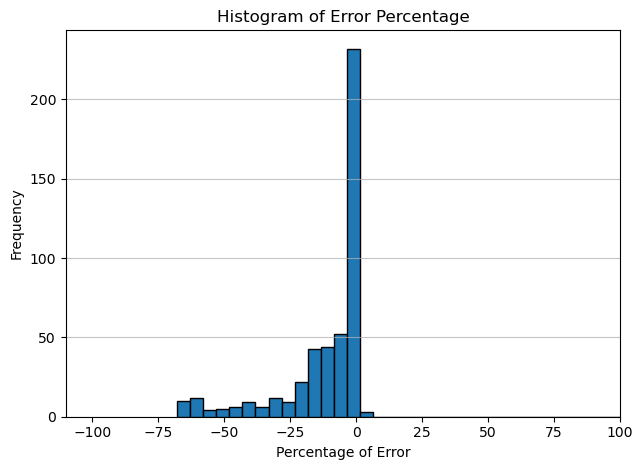

In [10]:
# Plotting histogram
plt.hist(error_percentage_list, bins=300, edgecolor='black') 
plt.xlabel('Percentage of Error')
plt.ylabel('Frequency')
plt.title('Histogram of Error Percentage')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.xlim(-110, 100)

plt.show()


In [11]:
print(error_percentage_list)

[-14.991429102522464, -41.14490376863264, -14.019481143527612, -14.146866375280274, -32.56729854587797, 0, -15.221892472448296, 0, 0, -7.023808183910231, 0, -3.764793282836243, -14.372017098414661, -0.033815242419688626, -10.42640126932358, 0, 0, 0, -61.013497146629014, 0, 0, 0, -15.481348424859453, 0, -3.342737049012112e-05, -0.5145276122831894, -34.72926098473991, 0.0010969356746146285, -15.925695876922259, 0, 0, 0, 0, -6.946898652496918, 0, -6.741430291805815, -7.224012879680145, -2.834379900783332, -19.61816294637391, 0, 0, 0, 0, -65.86257220261805, -9.659994762253756, 0, -9.843670083340617, 0.0012808769235117057, 0, 0.0016883507737464202, 0, -9.95872960586008, -19.523951175342525, -56.0220116103156, -38.25095006892755, -24.86538723007117, -41.88013161623142, -50.60278166309238, -1.6815331675803302, 0.000919044040042107, -2.1306371300890627, 0.004409560375566225, -2.0441150484260096, 0.7449560927810934, -22.33899507054881, 0, 0, -15.170030773878516, -15.525257651328644, 0, -15.7925

In [13]:

def display_original_image(image_path, image_hdu):
    fits_file_path = image_path
    sigma_clip = SigmaClip(sigma=5.0)
    sexbkg = SExtractorBackground(sigma_clip)
    zscale_interval = ZScaleInterval()
    print(image_path)
    # Open the FITS file
    hdul = fits.open(fits_file_path)
    print(hdul[image_hdu].header)

    try:
        if hdul[image_hdu].header['SKYBRITE'] is None:
            sky_brightness = 0
        else:
            sky_brightness = hdul[image_hdu].header['SKYBRITE']
    except KeyError:
        sky_brightness = 0
    image_data = hdul[image_hdu].data
    image_data_subtracted = image_data - float(sky_brightness)  # Subtract the sky_brightness

    fig, axs = plt.subplots(figsize=(10, 8))
    norm1 = ImageNormalize(image_data_subtracted, interval=zscale_interval)
    im1 = axs.imshow(image_data_subtracted, cmap='gray', norm=norm1)
    axs.set_title(f'Original Image - HDU {image_hdu}')
    fig.colorbar(im1, ax=axs, label='Counts')
    # Show the plot
    plt.show()
    

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141128/c4d_141128_031511_oki_Y_v1.fits.fz_38
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141128/c4d_141128_031511_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'N8      '           / Extension name                                 INHERIT =                    T / Inherits globa

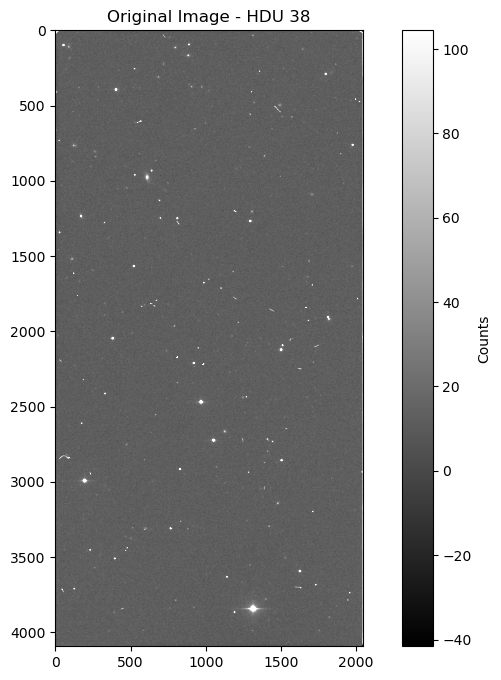

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161117/c4d_161117_045536_oki_Y_v1.fits.fz_18
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161117/c4d_161117_045536_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S8      '           / Extension name                                 FZQVALUE=                    4                   

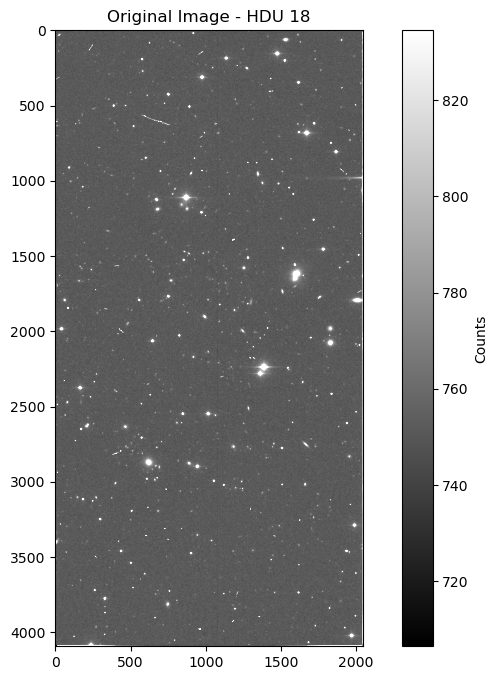

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150201/c4d_150201_042757_oki_Y_v1.fits.fz_2
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150201/c4d_150201_042757_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S31     '           / Extension name                                 IRAF-TLM= '2016-12-07T17:26:32' / Time of last m

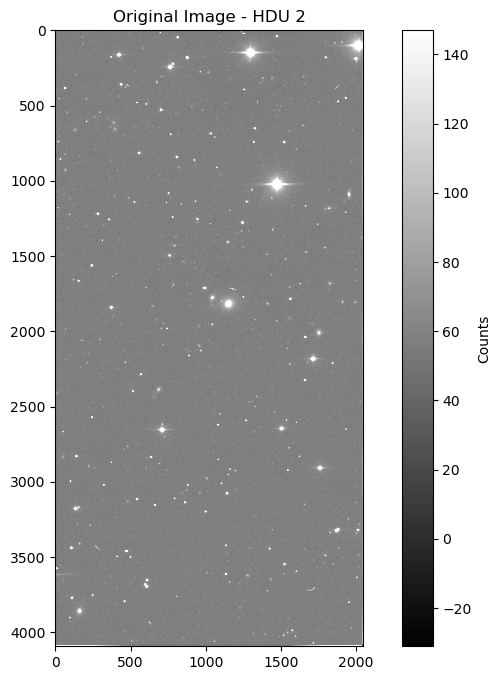

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150201/c4d_150201_042757_oki_Y_v1.fits.fz_27
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150201/c4d_150201_042757_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S4      '           / Extension name                                 INHERIT =                    T / Inherits globa

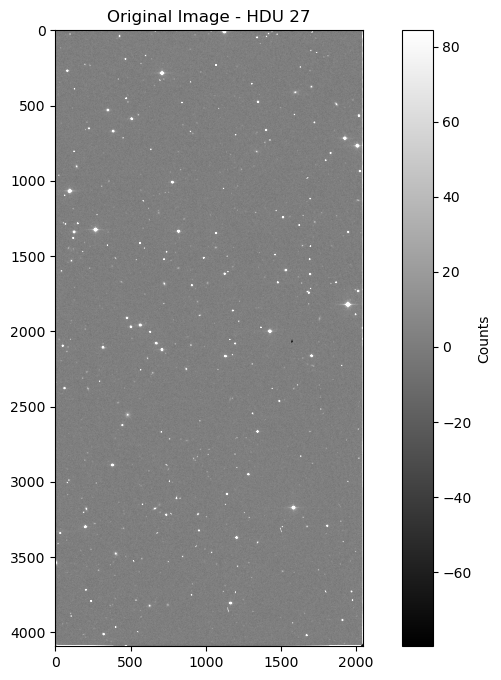

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150929/c4d_150929_001224_oki_Y_v1.fits.fz_18
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150929/c4d_150929_001224_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S8      '           / Extension name                                 IRAF-TLM= '2016-12-16T18:31:47' / Time of last 

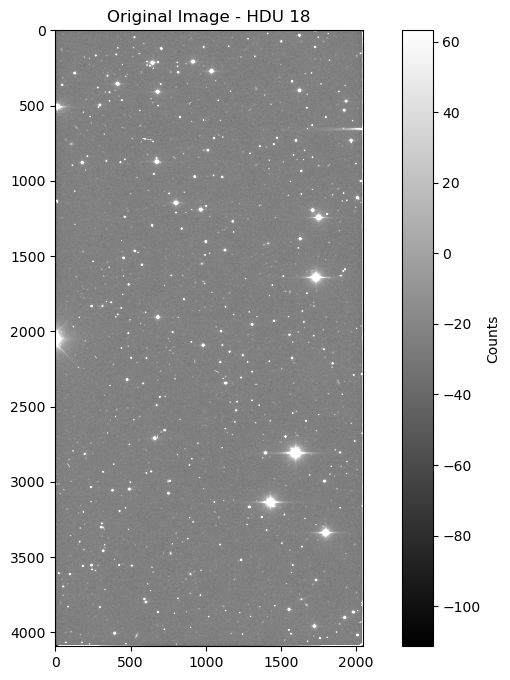

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_073851_oki_Y_v1.fits.fz_3
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_073851_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S25     '           / Extension name                                 INHERIT =                    T / Inherits global

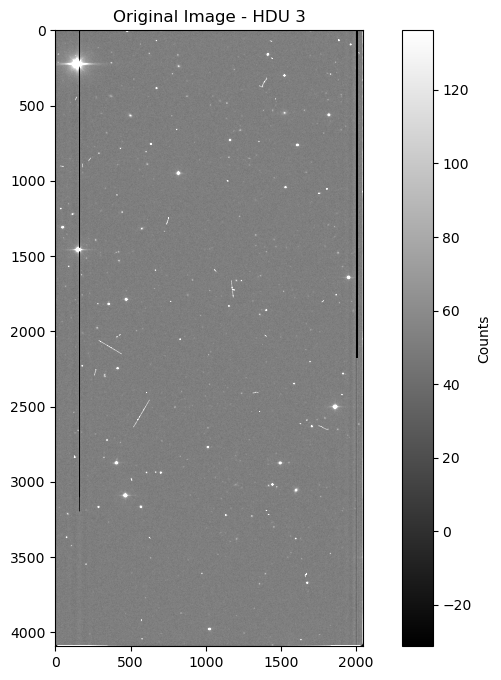

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20171023/c4d_171024_081630_oki_r_v1.fits.fz_40
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20171023/c4d_171024_081630_oki_r_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'N9      '           / Extension name                                 FZQVALUE=                    4                   

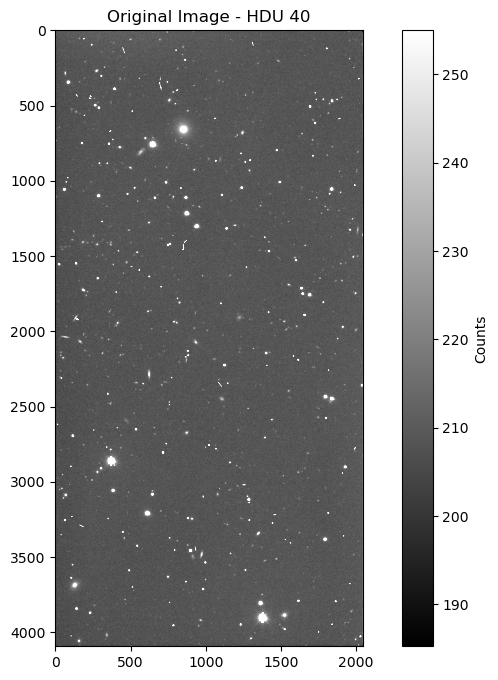

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141031/c4d_141031_020521_oki_Y_v1.fits.fz_49
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141031/c4d_141031_020521_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'N19     '           / Extension name                                 INHERIT =                    T / Inherits globa

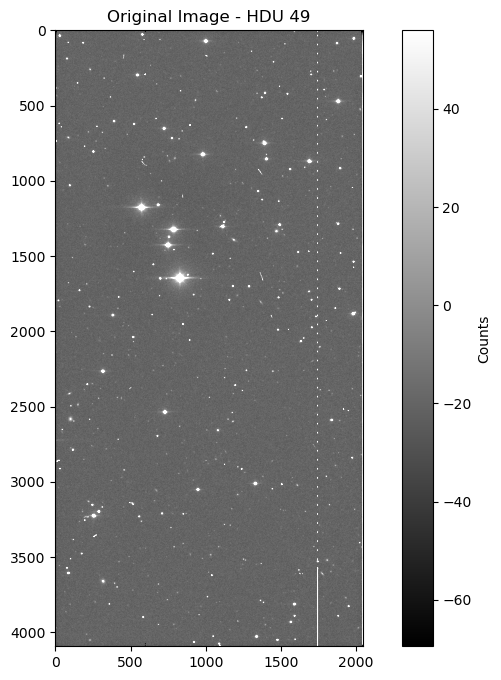

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.8/CP20130815/c4d_130815_033642_oki_i_v2.fits.fz_33
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.8/CP20130815/c4d_130815_033642_oki_i_v2.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'N2      '           / Extension name                                 INHERIT =                    T / Inherits global 

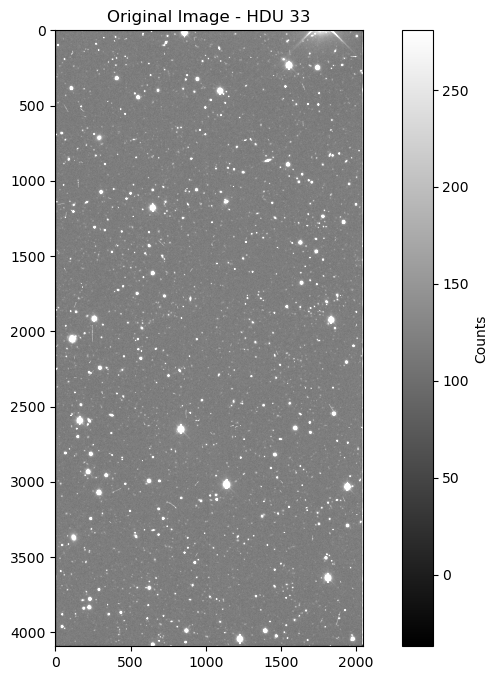

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150103/c4d_150103_052000_oki_Y_v1.fits.fz_7
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150103/c4d_150103_052000_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S20     '           / Extension name                                 INHERIT =                    T / Inherits global

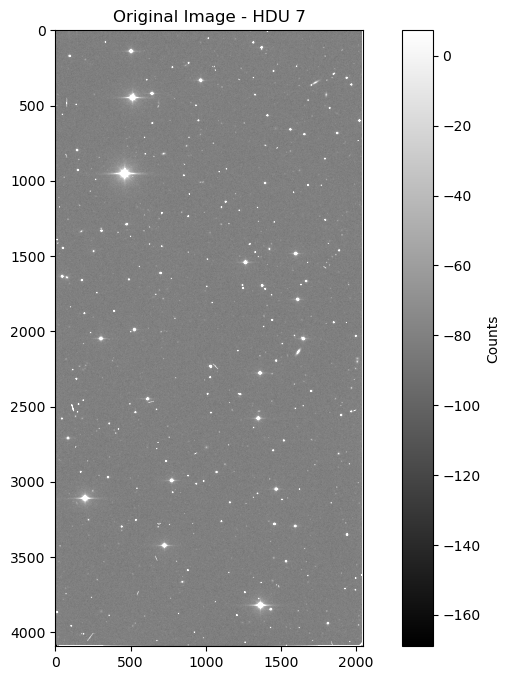

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151009/c4d_151009_091226_oki_Y_v1.fits.fz_41
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20151009/c4d_151009_091226_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'N11     '           / Extension name                                 INHERIT =                    T / Inherits globa

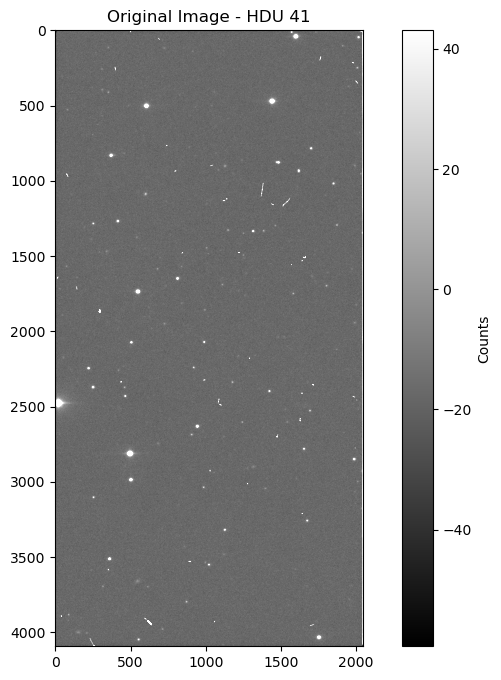

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150927/c4d_150927_024358_oki_Y_v1.fits.fz_55
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150927/c4d_150927_024358_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'N25     '           / Extension name                                 INHERIT =                    T / Inherits globa

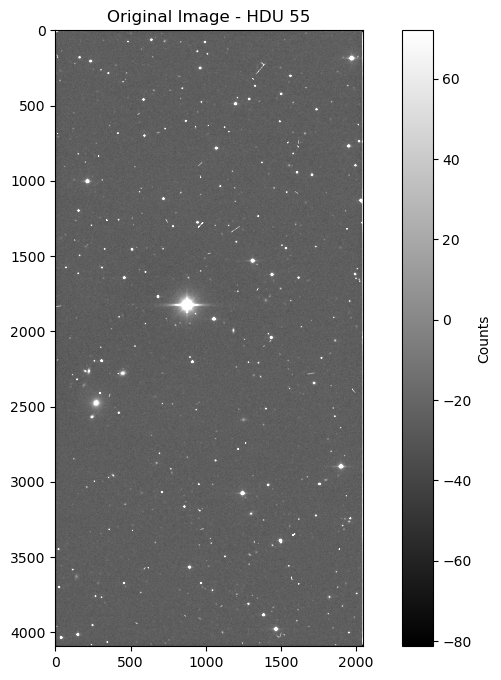

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150103/c4d_150103_050817_oki_Y_v1.fits.fz_21
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150103/c4d_150103_050817_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S11     '           / Extension name                                 INHERIT =                    T / Inherits globa

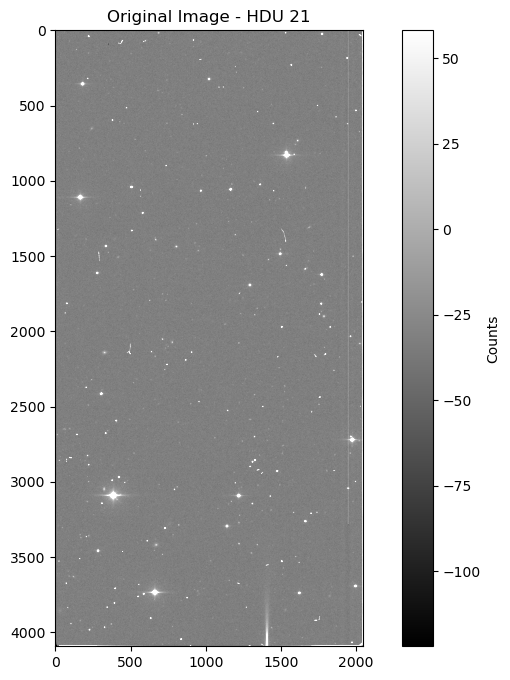

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150103/c4d_150103_050817_oki_Y_v1.fits.fz_54
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150103/c4d_150103_050817_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'N24     '           / Extension name                                 INHERIT =                    T / Inherits globa

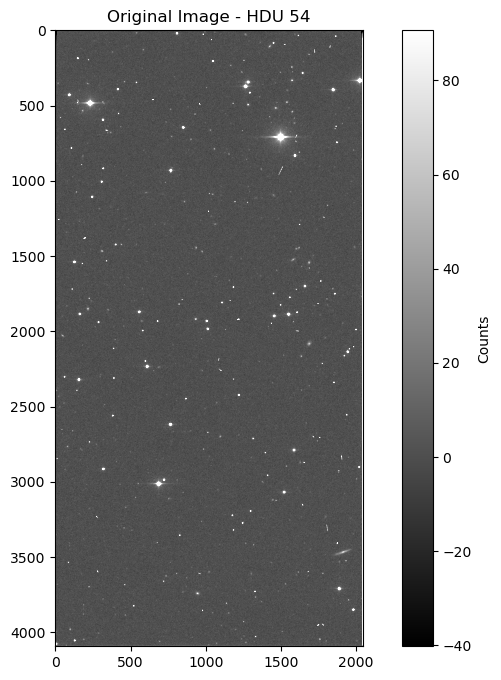

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161207/c4d_161207_041440_oki_Y_v1.fits.fz_17
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161207/c4d_161207_041440_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S19     '           / Extension name                                 FZQVALUE=                    4                   

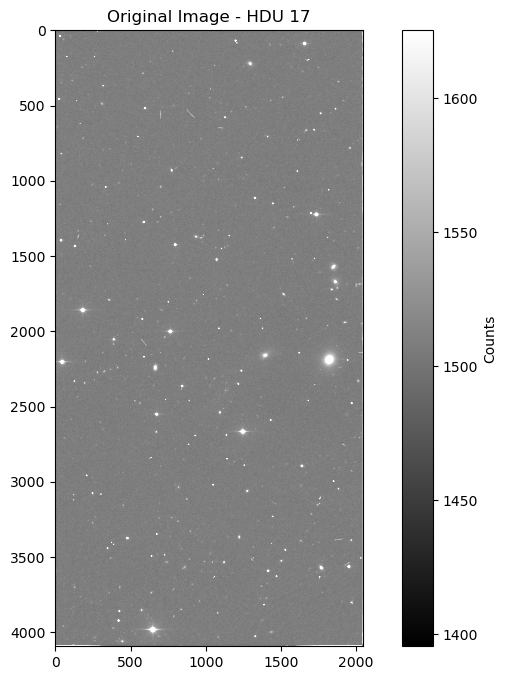

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161207/c4d_161207_041440_oki_Y_v1.fits.fz_30
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161207/c4d_161207_041440_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S7      '           / Extension name                                 FZQVALUE=                    4                   

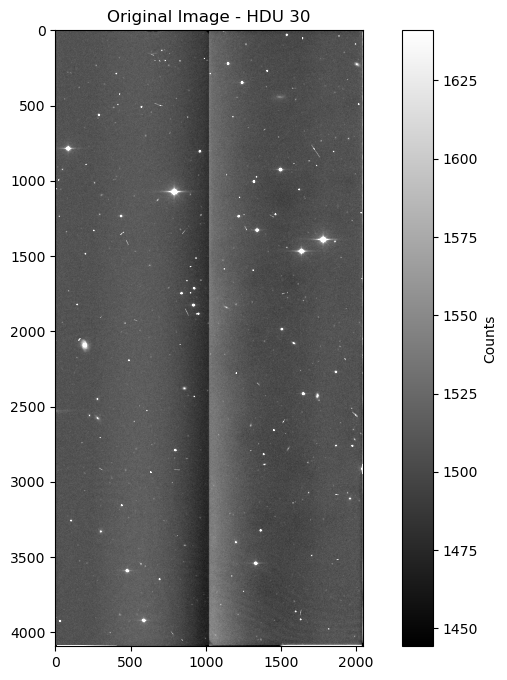

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161219/c4d_161219_035121_oki_Y_v1.fits.fz_28
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20161219/c4d_161219_035121_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S5      '           / Extension name                                 FZQVALUE=                    4                   

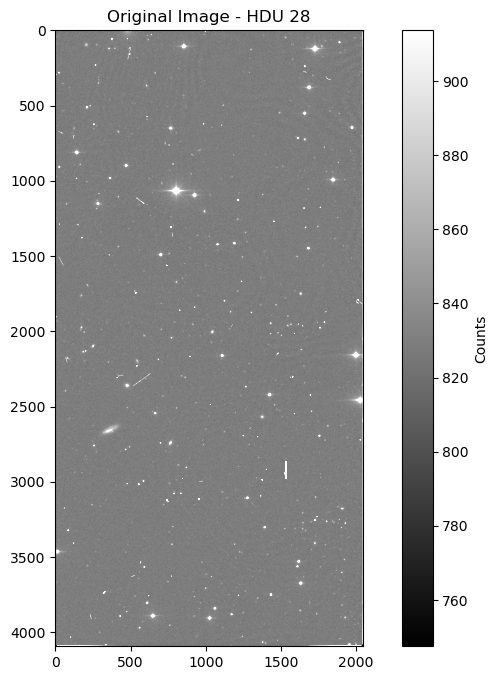

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141103/c4d_141103_055249_oki_Y_v1.fits.fz_8
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141103/c4d_141103_055249_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S21     '           / Extension name                                 INHERIT =                    T / Inherits global

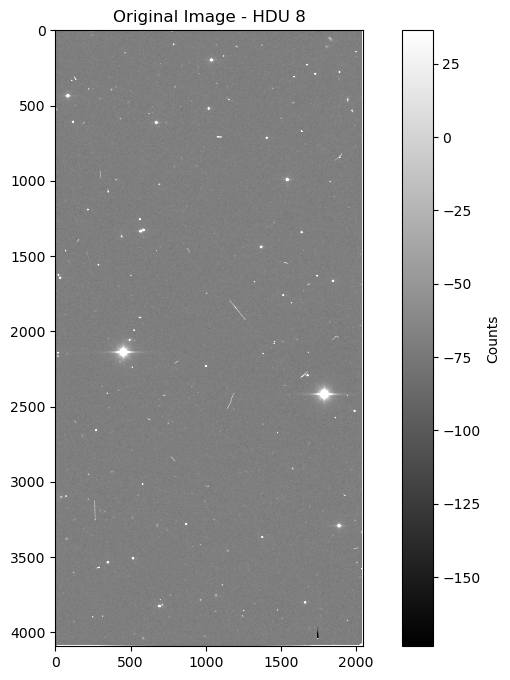

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141103/c4d_141103_055249_oki_Y_v1.fits.fz_3
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141103/c4d_141103_055249_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S25     '           / Extension name                                 INHERIT =                    T / Inherits global

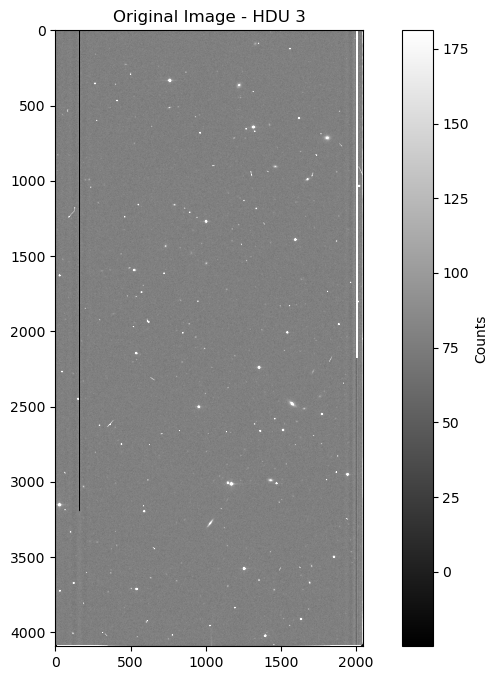

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141103/c4d_141103_055249_oki_Y_v1.fits.fz_48
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141103/c4d_141103_055249_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'N18     '           / Extension name                                 INHERIT =                    T / Inherits globa

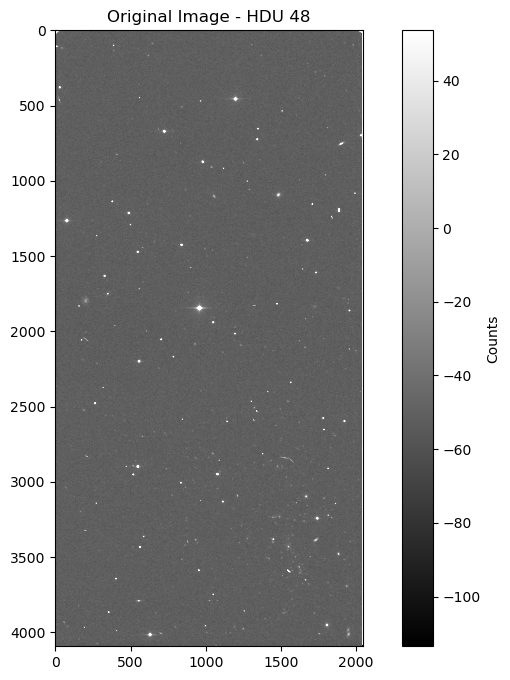

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9/CP20151231/c4d_151231_072204_oki_i_v1.fits.fz_16
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9/CP20151231/c4d_151231_072204_oki_i_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S18     '           / Extension name                                 INHERIT =                    T / Inherits global 

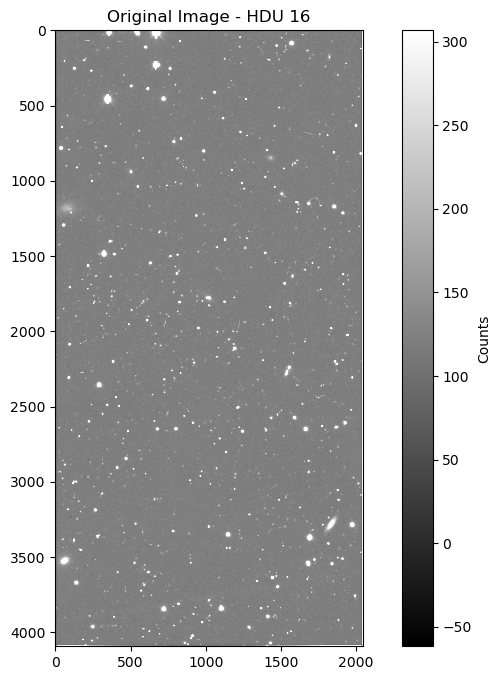

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150929/c4d_150929_064924_oki_Y_v1.fits.fz_23
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20150929/c4d_150929_064924_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S13     '           / Extension name                                 INHERIT =                    T / Inherits globa

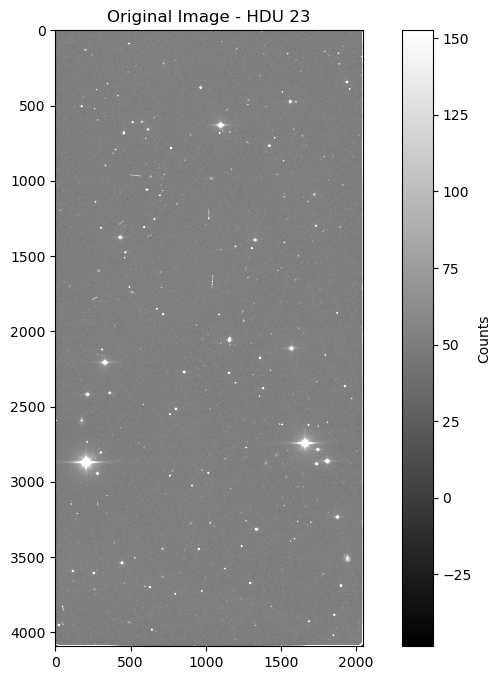

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141030/c4d_141030_031413_oki_Y_v1.fits.fz_31
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141030/c4d_141030_031413_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'N1      '           / Extension name                                 INHERIT =                    T / Inherits globa

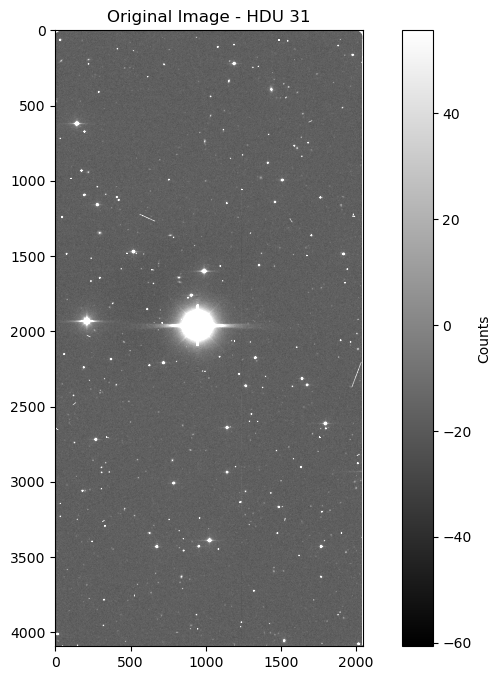

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20160213/c4d_160213_022351_oki_Y_v1.fits.fz_43
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20160213/c4d_160213_022351_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'N13     '           / Extension name                                 INHERIT =                    T / Inherits globa

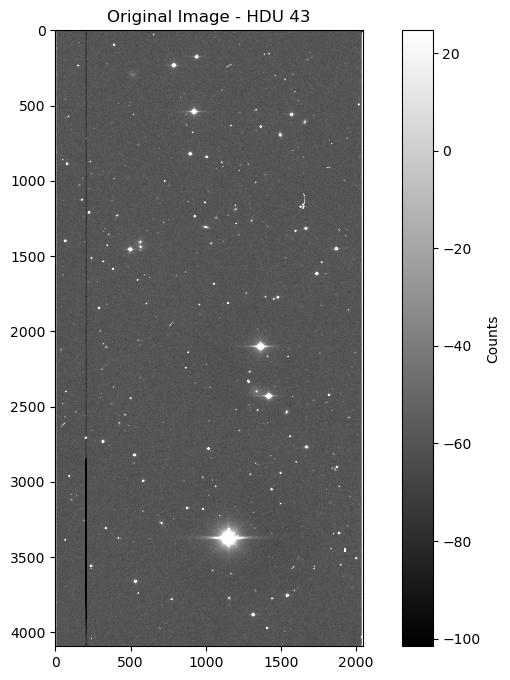

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141114/c4d_141114_055130_oki_Y_v1.fits.fz_27
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141114/c4d_141114_055130_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S4      '           / Extension name                                 INHERIT =                    T / Inherits globa

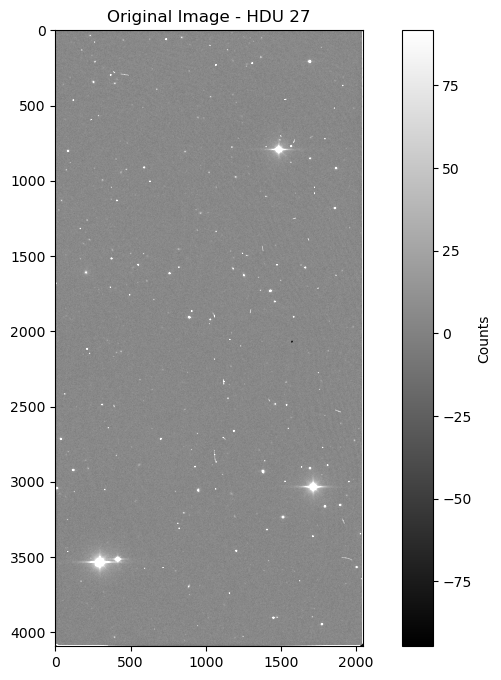

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170423/c4d_170423_231204_oki_i_v1.fits.fz_21
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V4.1/CP20170423/c4d_170423_231204_oki_i_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S10     '           / Extension name                                 FZQVALUE=                    4                   

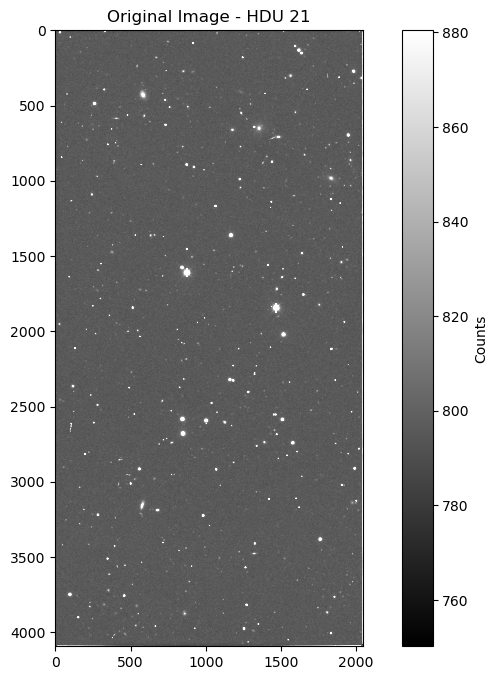

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_052822_oki_Y_v1.fits.fz_46
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_052822_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'N16     '           / Extension name                                 INHERIT =                    T / Inherits globa

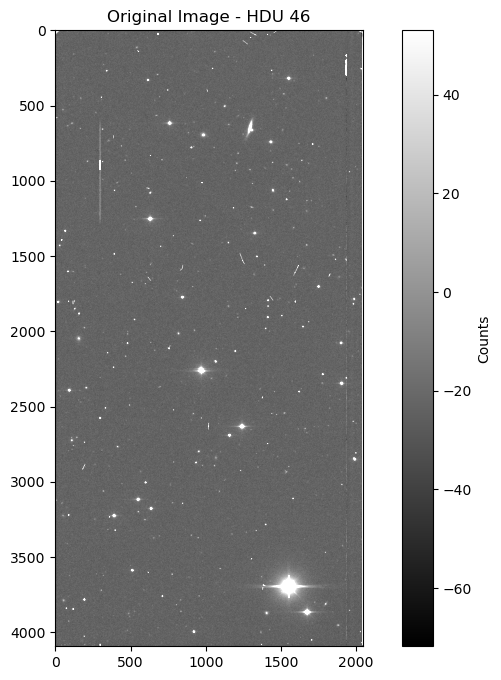

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_055532_oki_Y_v1.fits.fz_34
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.10/CP20141104/c4d_141104_055532_oki_Y_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'N4      '           / Extension name                                 INHERIT =                    T / Inherits globa

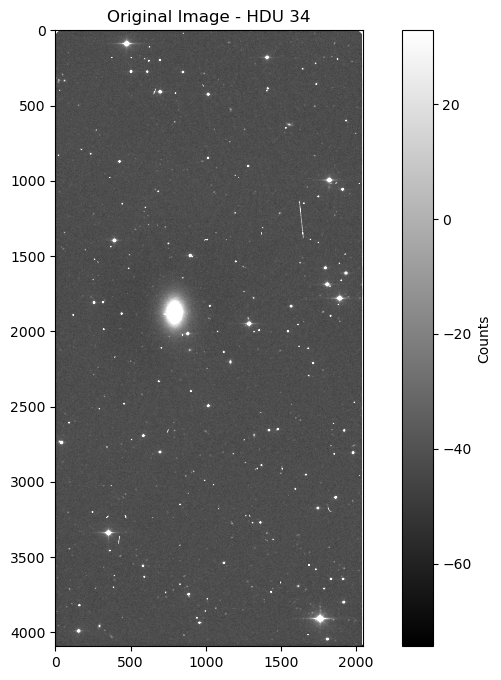

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20160706/c4d_160706_071303_oki_i_v1.fits.fz_2
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20160706/c4d_160706_071303_oki_i_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S31     '           / Extension name                                 IRAF-TLM= '2016-07-13T22:06:52' / Time of last

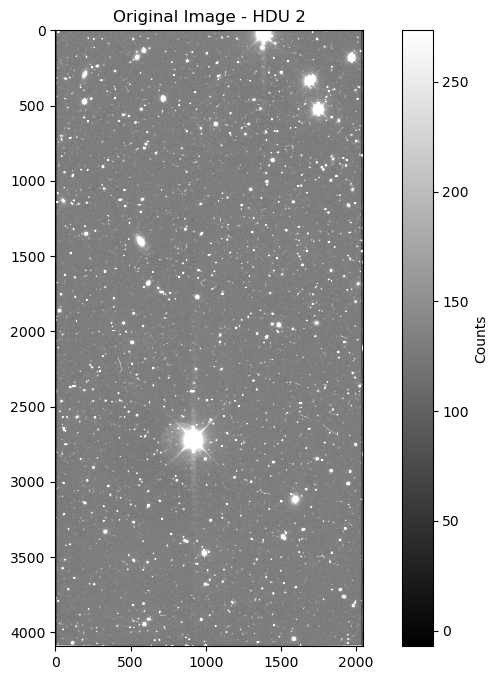

/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20160706/c4d_160706_071303_oki_i_v1.fits.fz_5
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.9.2/CP20160706/c4d_160706_071303_oki_i_v1.fits.fz
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2046 / Axis length                                    NAXIS2  =                 4094 / Axis length                                    PCOUNT  =                    0 / No 'random' parameters                         GCOUNT  =                    1 / Only one group                                 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        EXTNAME = 'S27     '           / Extension name                                 INHERIT =                    T / Inherits glob

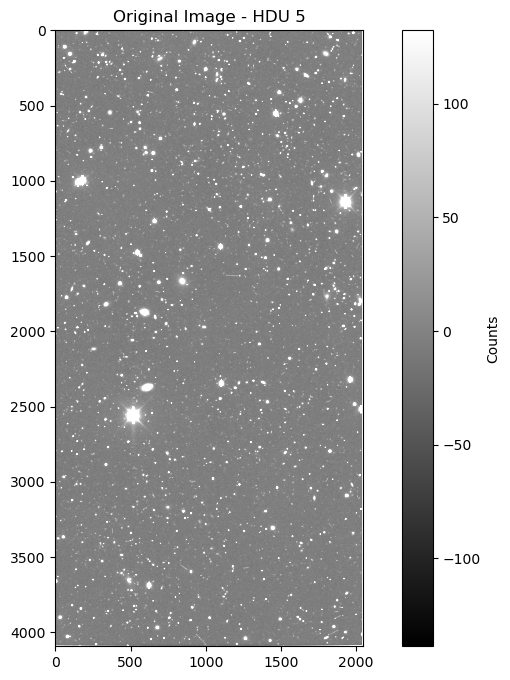

In [14]:
import re

for bad_image in bad_images:
    print(bad_image)
    hdu_number = bad_image.split('_')[-1].split('.')[0]  # Extracting HDU number
    path = '_'.join(bad_image.split('_')[:-1])  # Extracting path
    display_original_image(path, int(hdu_number))

    
